# Visualize the model performance after using tab_err on the test set.

We run experiments on the downstream performance of ML models on both clean and errored test data.

The error models selected were all tuples of {Outlier, Wrong Unit Scale} x {Typo, Extraneous} yielding 4 combinations that ensured all columns were affected by errors in the experiment.

The criteria for choosing datasets:

- Less than 100,000 rows and 100 columns

- From the Tree Based Methods Paper

See the bit on how we compare performance later in the notebook.

In [1]:

import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines


In [2]:
def aggregate_results(root_dir):
    """Aggregate error metric scores from result.csv files in a nested directory structure.
    
    Args:
        root_dir (str): The top-level directory path, e.g., 'classificaiton-tab-err-outlier'
    
    Returns:
        pd.DataFrame: Multi-indexed DataFrame with avergae scores for each (error_type, error_rate, mechanism, metric)
    """
    raw_records = []
    
    for dataset_id in os.listdir(root_dir):
        dataset_path = os.path.join(root_dir, dataset_id)
        if not os.path.join(root_dir, dataset_id):
            continue
    
        for error_rate in os.listdir(dataset_path):
            rate_path = os.path.join(dataset_path, error_rate)
            results_file = os.path.join(rate_path, 'results.csv')
            if not os.path.isfile(results_file):
                continue
    
            df = pd.read_csv(results_file)  # Rows: metric, columns: metadata/metric values
    
            for _, row in df.iterrows():
                for mechanism in ["ECAR", "EAR", "ENAR"]:
                    raw_records.append({
                        'error_type': os.path.basename(root_dir),
                        'dataset_id': dataset_id,
                        'error_rate': float(error_rate),
                        'mechanism': mechanism,
                        'metric': row['evaluation_metric'],
                        'score': max(row[mechanism] - row['clean'], -5) # Delta from clean (if negative, clean performed better; if positive, dirty performed better). Clip at -5
                    })
    
    return pd.DataFrame(raw_records)


In [3]:
clf_outlier_extraneous = aggregate_results("clf-outlier-extraneous")
clf_outlier_typo = aggregate_results("clf-outlier-typo")
clf_wrongunit_extraneous = aggregate_results("clf-wrongunit-extraneous")
clf_wrongunit_typo = aggregate_results("clf-wrongunit-typo")

reg_outlier_extraneous = aggregate_results("reg-outlier-extraneous")
reg_outlier_typo = aggregate_results("reg-outlier-typo")
reg_wrongunit_extraneous = aggregate_results("reg-wrongunit-extraneous")
reg_wrongunit_typo = aggregate_results("reg-wrongunit-typo")

reg_wrongunit_typo.head()

,error_type,dataset_id,error_rate,mechanism,metric,score
0,reg-wrongunit-typo,44025,0.1,ECAR,r2_score,-0.294599
1,reg-wrongunit-typo,44025,0.1,EAR,r2_score,-0.176107
2,reg-wrongunit-typo,44025,0.1,ENAR,r2_score,-0.364517
3,reg-wrongunit-typo,44025,0.1,ECAR,r2_score,-0.271339
4,reg-wrongunit-typo,44025,0.1,EAR,r2_score,-0.622232


Number of clf datasets

In [10]:
len(clf_wrongunit_extraneous.groupby("dataset_id").size())

15

Violin plots of all datasets

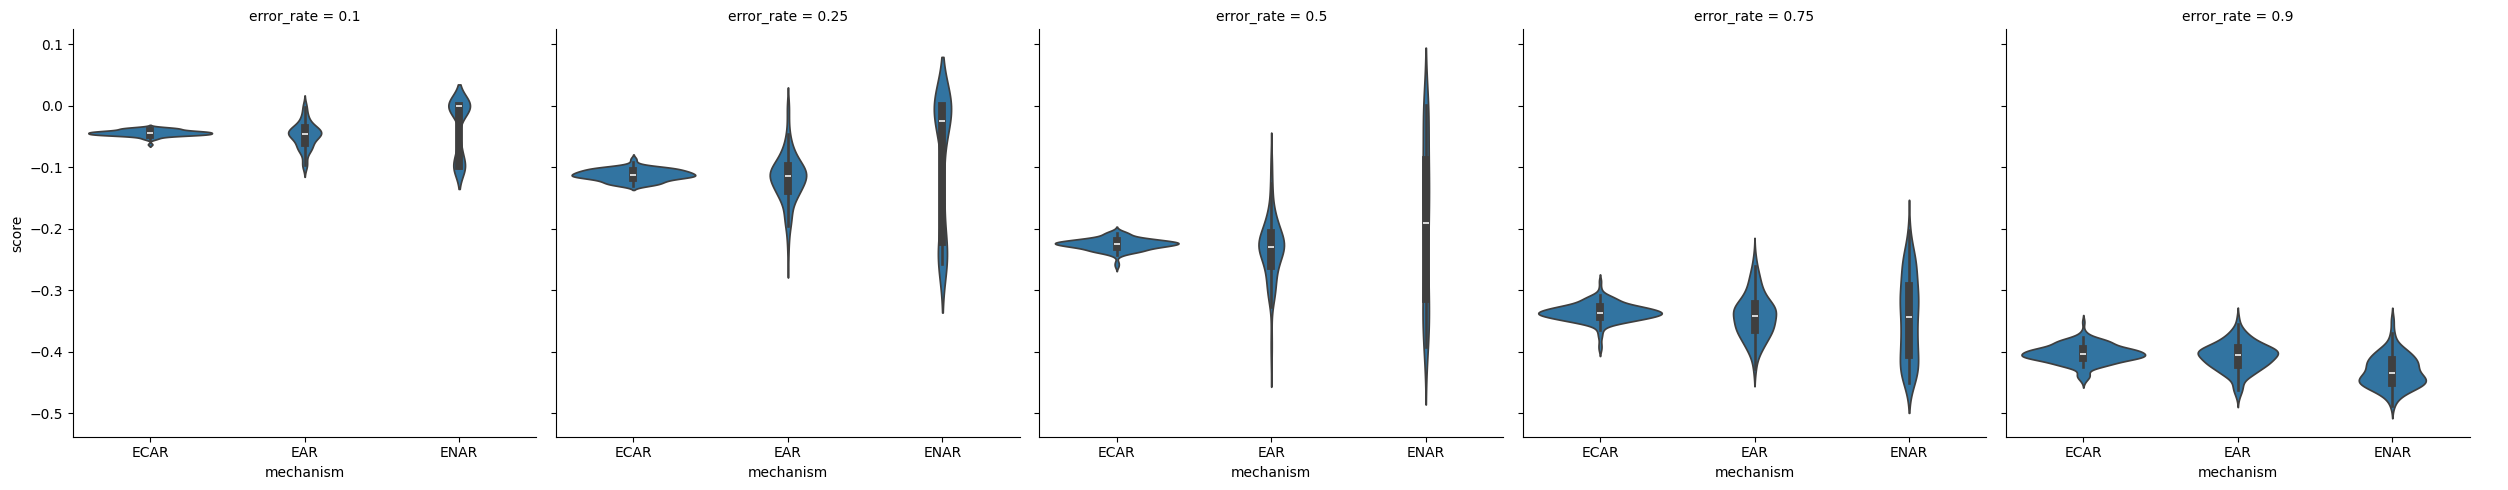

In [13]:
sns.catplot(clf_wrongunit_extraneous, x="mechanism", y="score", col="error_rate", kind="violin")

Violin plots of each dataset

In [ ]:

sns.catplot(clf_wrongunit_extraneous, x="mechanism", y="score", col="error_rate", row="dataset_id", kind="violin")

In [5]:
def plot_boxplots_by_error_rate(df, title_prefix="Boxplots"):
    error_rates = sorted(df['error_rate'].unique())
    num_rates = len(error_rates)
    metric_name = df['metric'][0]  # should be the same for all
    
    fig, axes = plt.subplots(1, num_rates, figsize=(4*num_rates, 5), sharey=True)
    
    if num_rates == 1:
        axes = [axes]
    
    for ax, rate in zip(axes, error_rates):
        subset = df[df['error_rate'] == rate]
        sns.boxplot(x="mechanism", y="score", data=subset, ax=ax, order=["ECAR", "EAR", "ENAR"])
        ax.axhline(0, linestyle='--', color='gray', linewidth=1)  # dotted line at y=0
        ax.set_title(f"Error Rate: {rate}")
        ax.set_xlabel("Category")
        ax.set_ylabel(f"Dirty - Clean {metric_name}")
    
    plt.suptitle(f"{title_prefix} for respective datasets", fontsize=41)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
def plot_ecdfs_by_error_rate(df, title_prefix="ECDFs"):
    error_rates = sorted(df['error_rate'].unique())
    num_rates = len(error_rates)
    metric_name = df['metric'].iloc[0]  # should be the same for all
    
    fig, axes = plt.subplots(1, num_rates, figsize=(5*num_rates, 5), sharey=True)
    
    if num_rates == 1:
        axes = [axes]
    
    for ax, rate in zip(axes, error_rates):
        subset = df[df['error_rate'] == rate]
        sns.ecdfplot(data=subset, x="score", hue="mechanism", ax=ax, hue_order=["ECAR", "EAR", "ENAR"])
        ax.axvline(0, linestyle='--', color='gray', linewidth=1)  # vertical line at x=0
        ax.set_title(f"Error Rate: {rate}")
        ax.set_xlabel(f"Dirty - Clean {metric_name}")
        ax.set_ylabel("ECDF")
        handles = [
            mlines.Line2D([], [], color=sns.color_palette()[0], label='ECAR'),
            mlines.Line2D([], [], color=sns.color_palette()[1], label='EAR'),
            mlines.Line2D([], [], color=sns.color_palette()[2], label='ENAR')
        ]
        ax.legend(handles=handles, title="mechanism")
    
    plt.suptitle(f"{title_prefix} for respective datasets", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Performance relative to clean data

Computed "delta value" : max(dirty_score - clean_score, -5)

Done row wise, per cv run.

- Positive values indicate better performance of dirty relative to clean

- 0 indicates equal performance

- Negative values indicate worse performance of dirty relative to clean

Anything less than -5 is already substatially worse than the clean data --> just clip it there.

Justification:

- R_sqd = 1 -> perfect fit of model to data.

- R_sqd = 0 -> performance equal to predicting the mean. 1 - ssr/sst = 0 if y_hat = y_bar

- R_sqd < 0 -> performance of model is worse than predicting the mean.

If delta value is less than -1, the dirty score is worse than predicting the mean (y_bar).

Boxplots

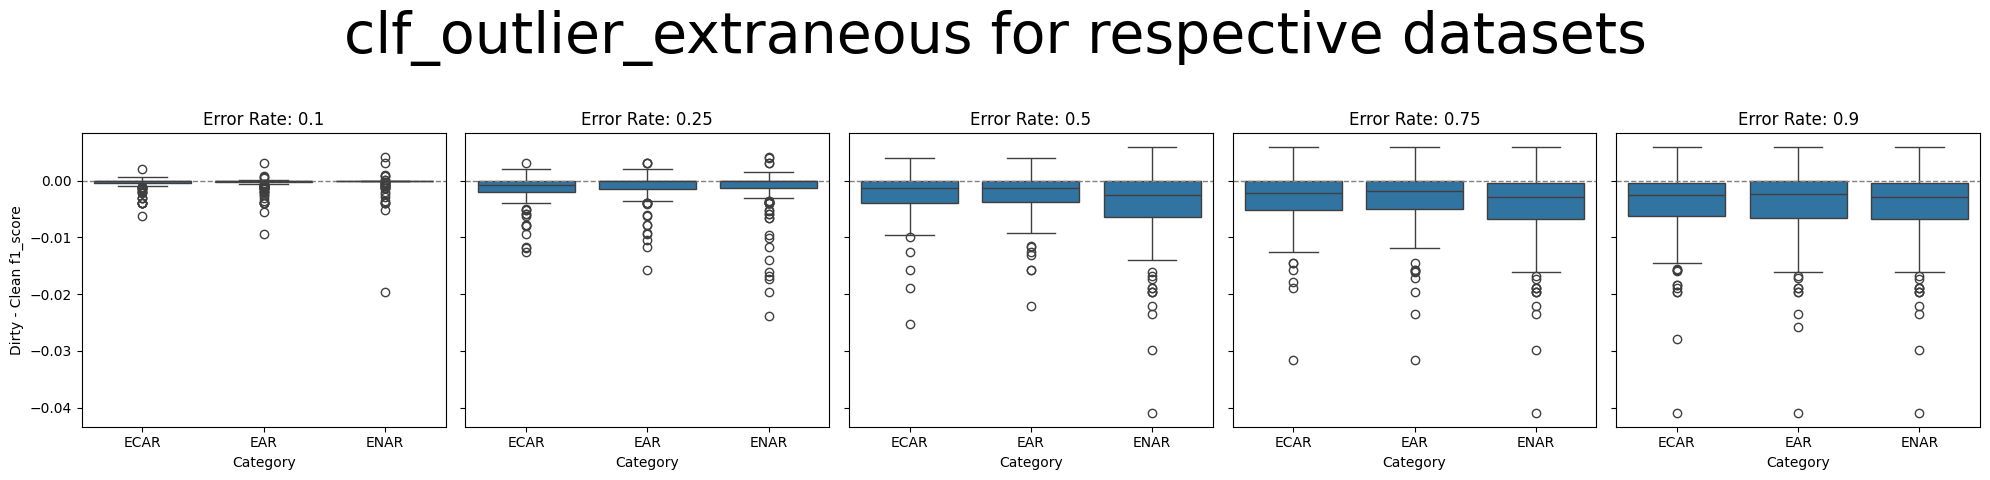

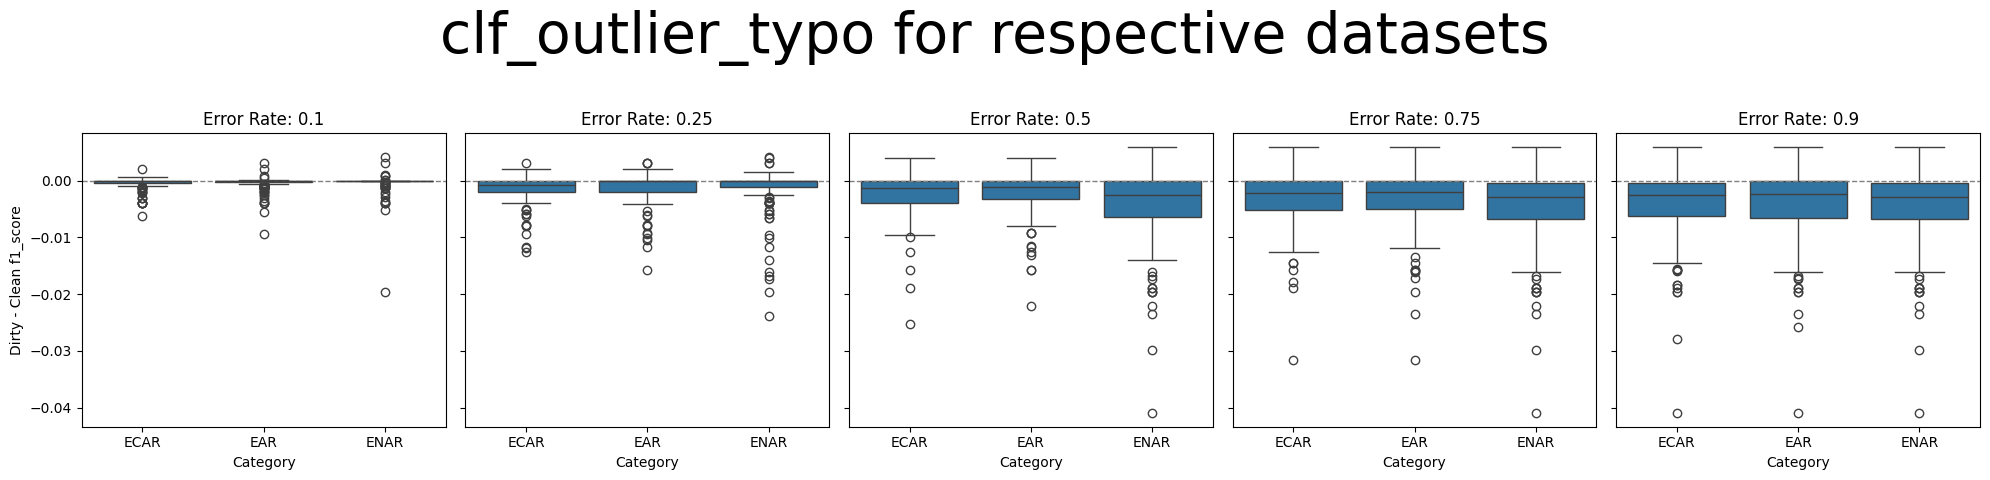

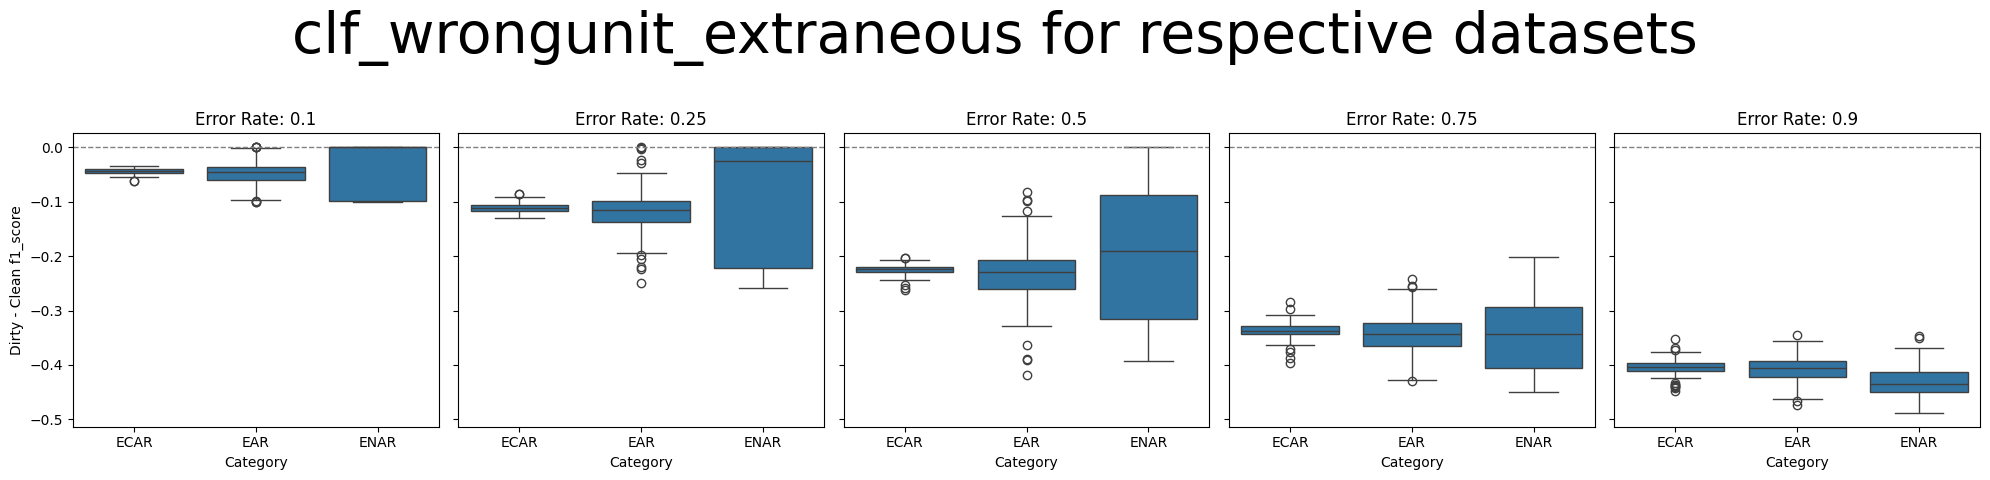

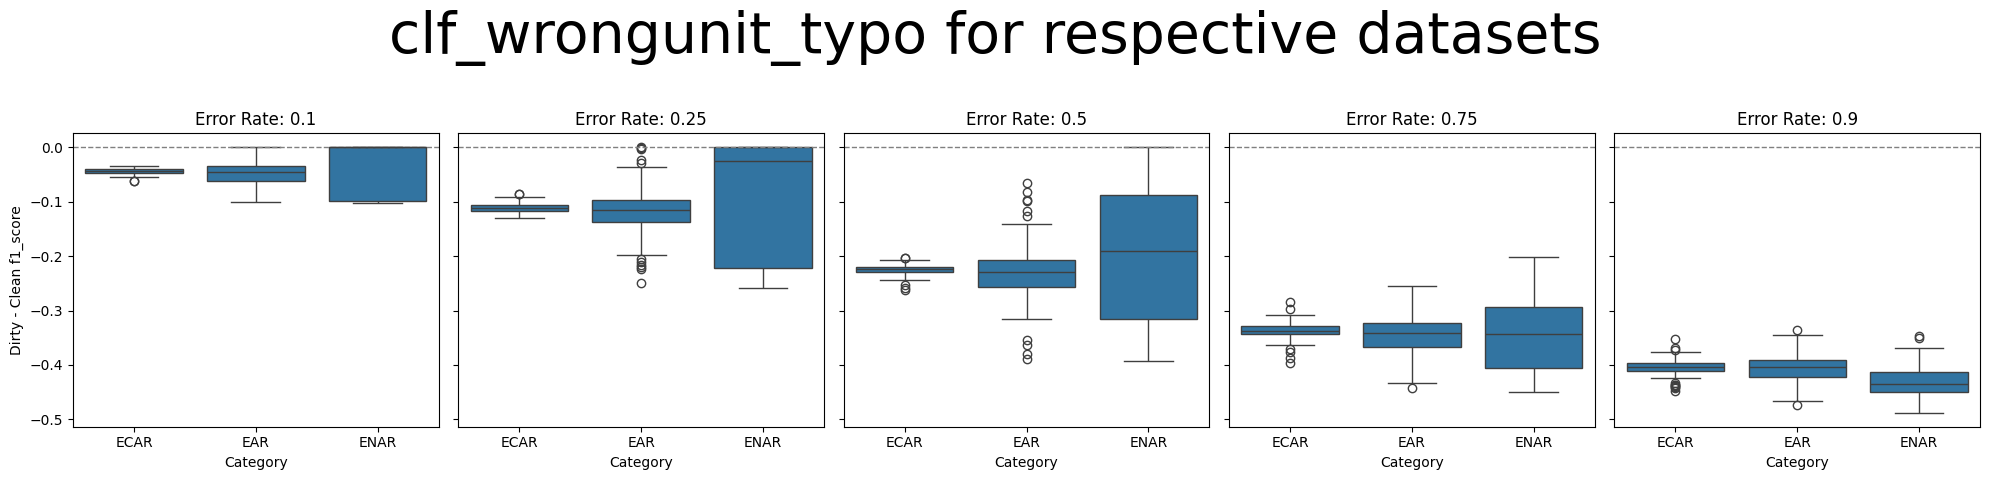

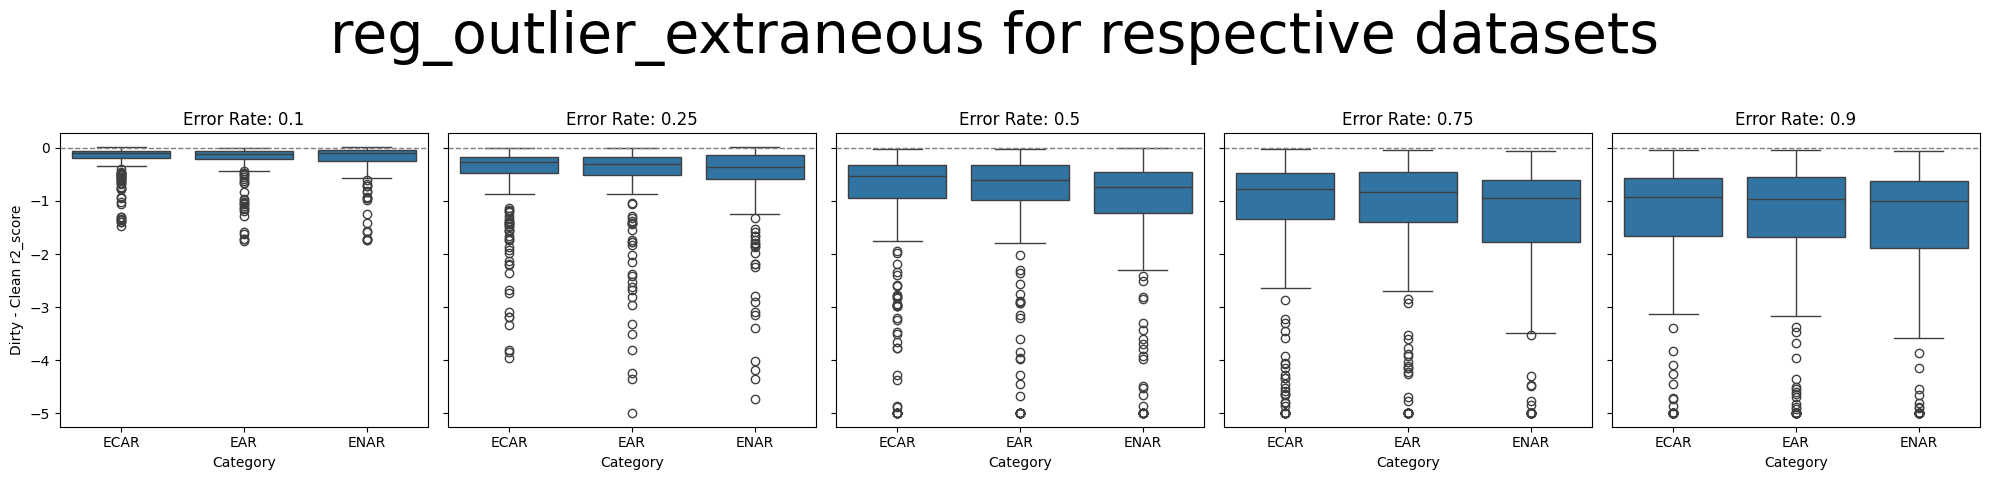

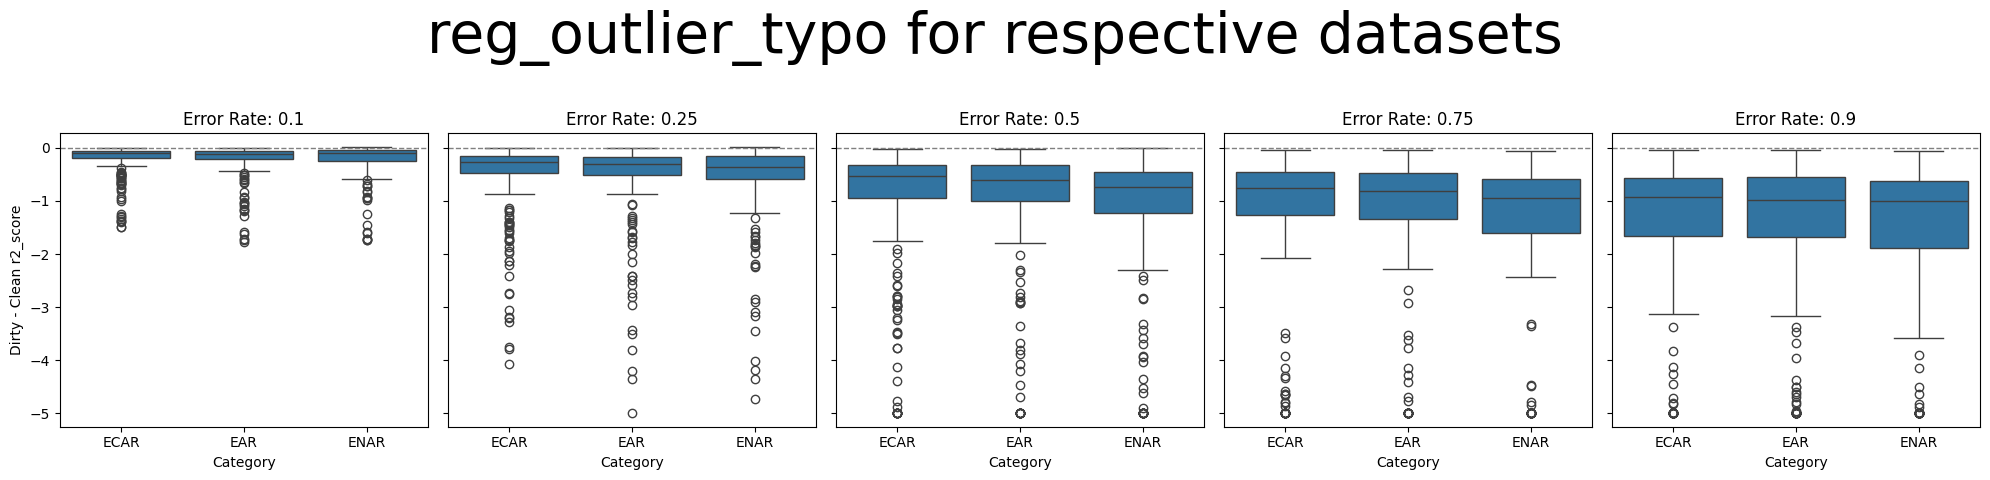

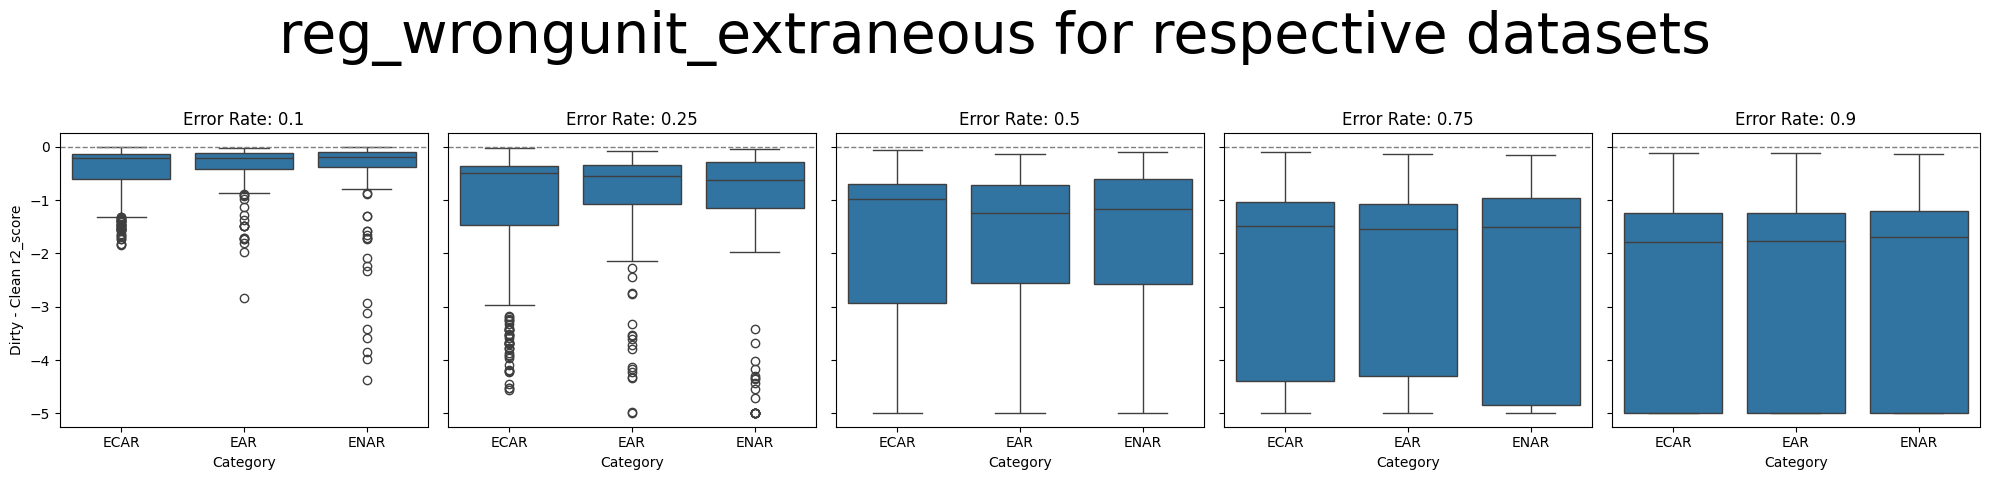

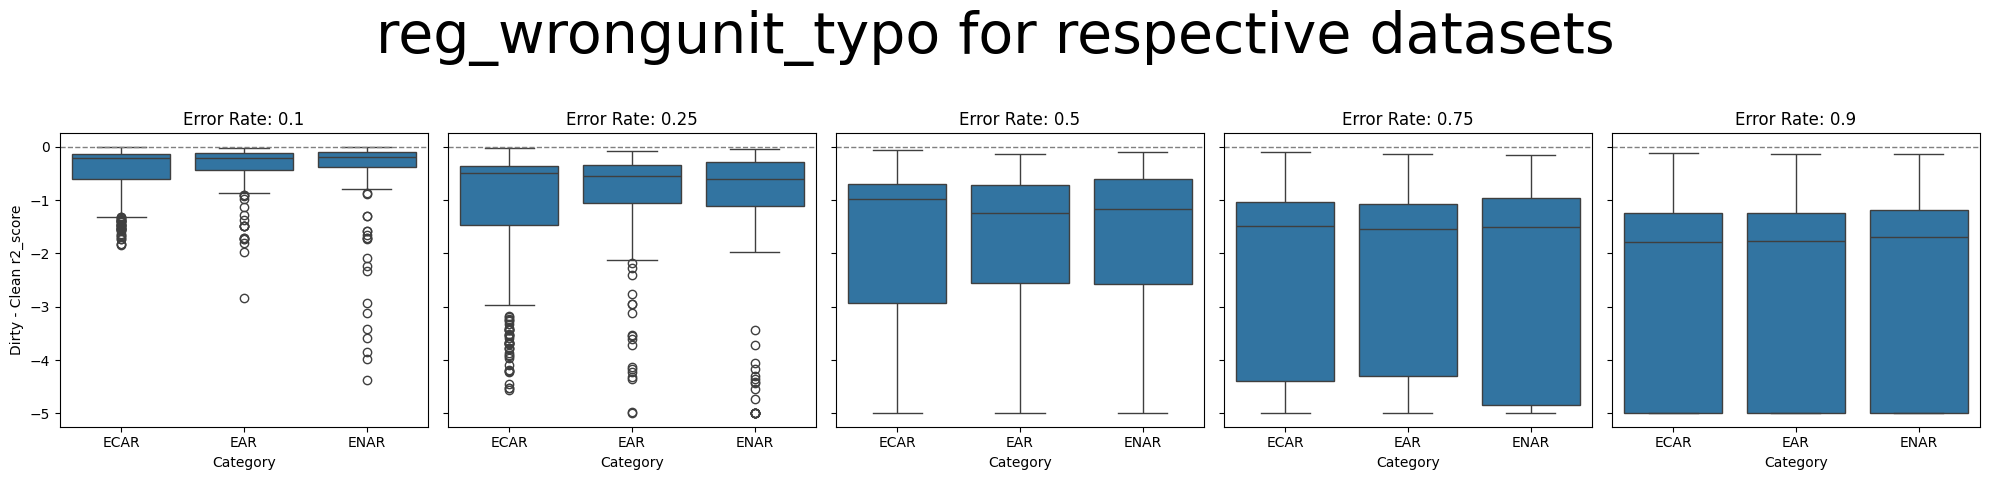

In [ ]:

plot_boxplots_by_error_rate(clf_outlier_extraneous, "clf_outlier_extraneous")
plot_boxplots_by_error_rate(clf_outlier_typo, "clf_outlier_typo")
plot_boxplots_by_error_rate(clf_wrongunit_extraneous, "clf_wrongunit_extraneous")
plot_boxplots_by_error_rate(clf_wrongunit_typo, "clf_wrongunit_typo")


plot_boxplots_by_error_rate(reg_outlier_extraneous, "reg_outlier_extraneous")
plot_boxplots_by_error_rate(reg_outlier_typo, "reg_outlier_typo")
plot_boxplots_by_error_rate(reg_wrongunit_extraneous, "reg_wrongunit_extraneous")
plot_boxplots_by_error_rate(reg_wrongunit_typo, "reg_wrongunit_typo")



Grouped by numeric error type

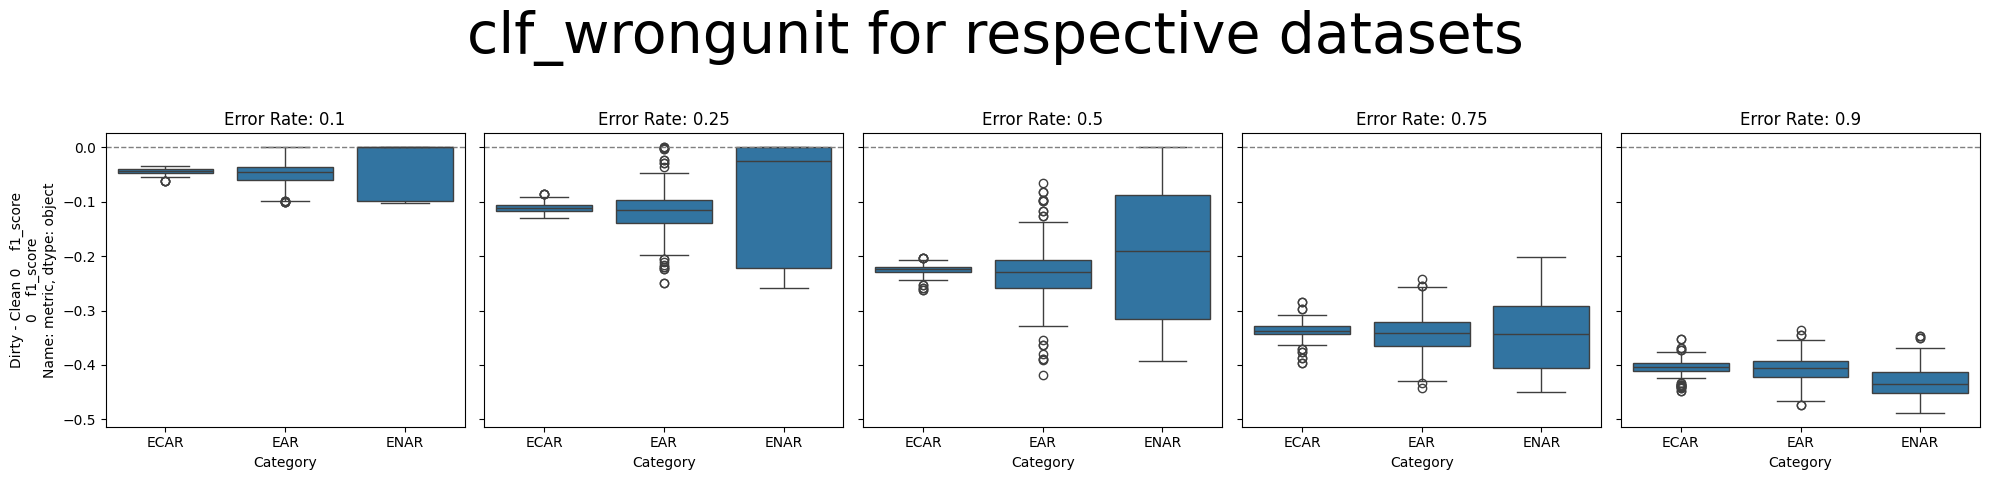

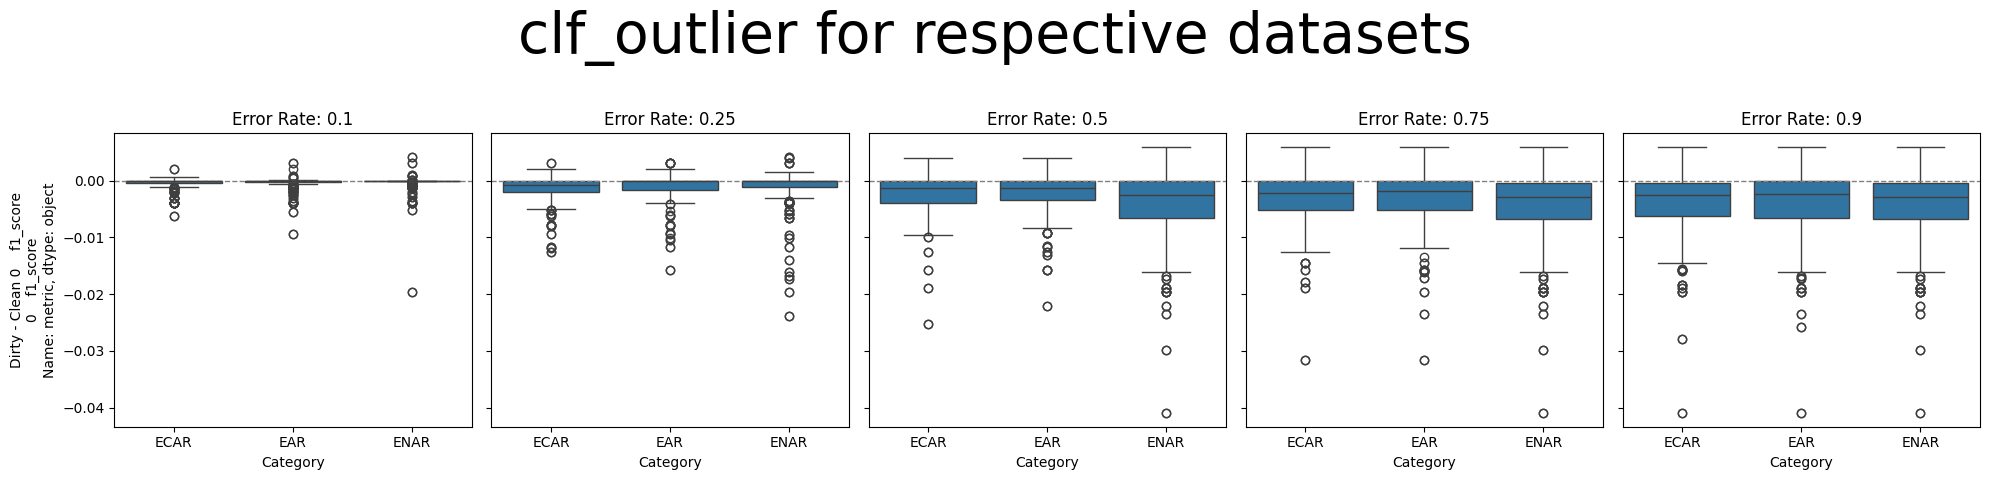

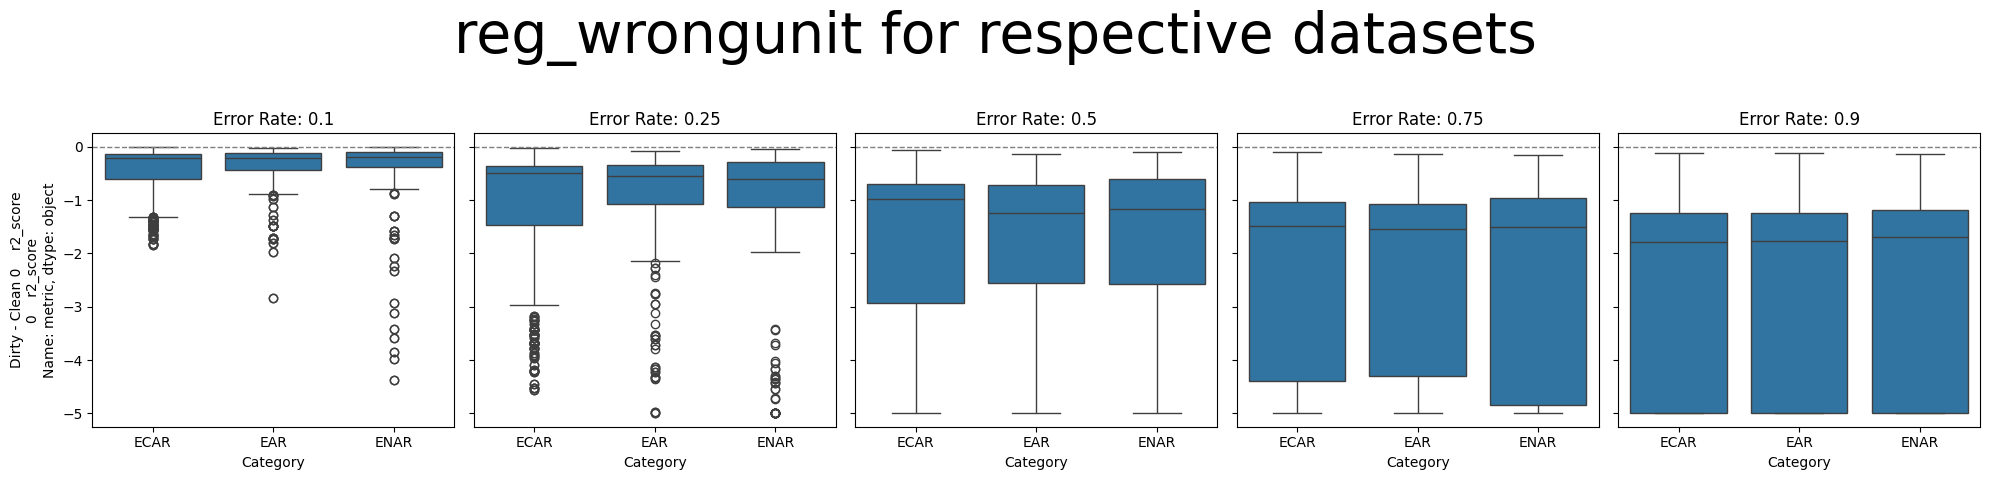

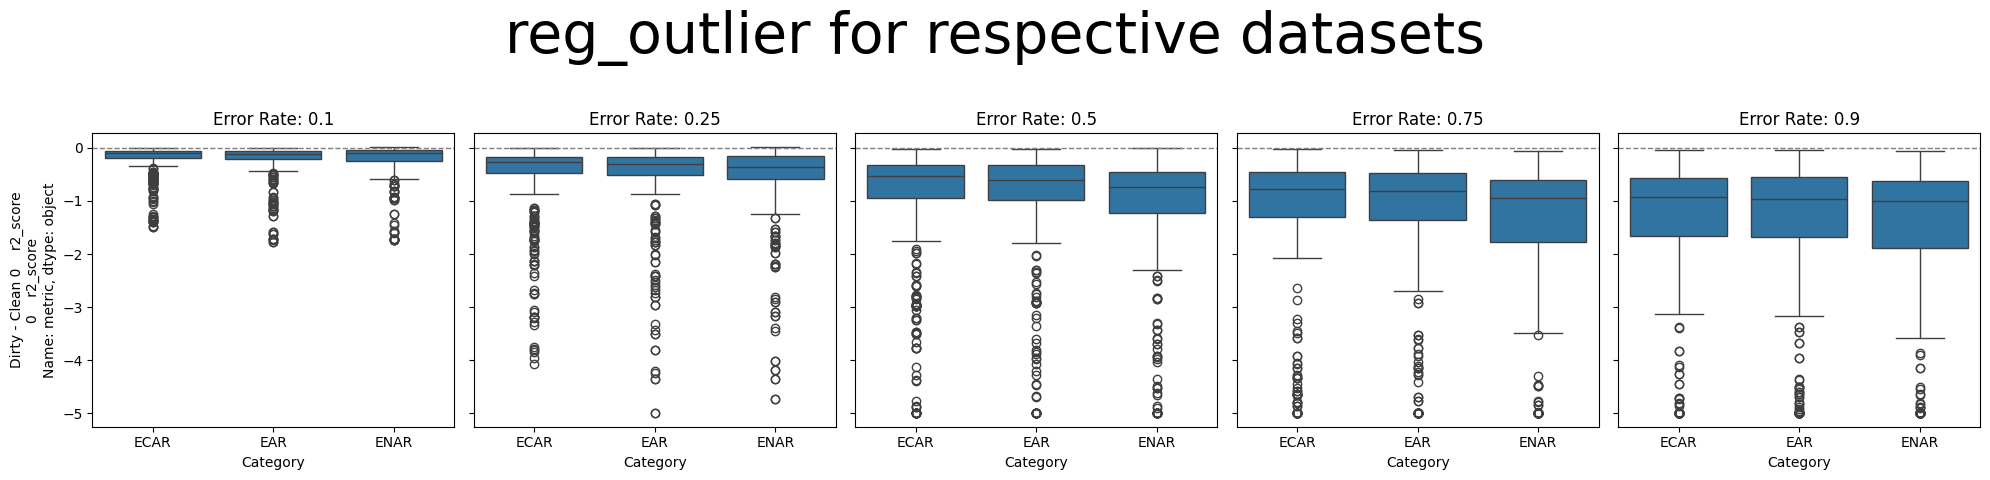

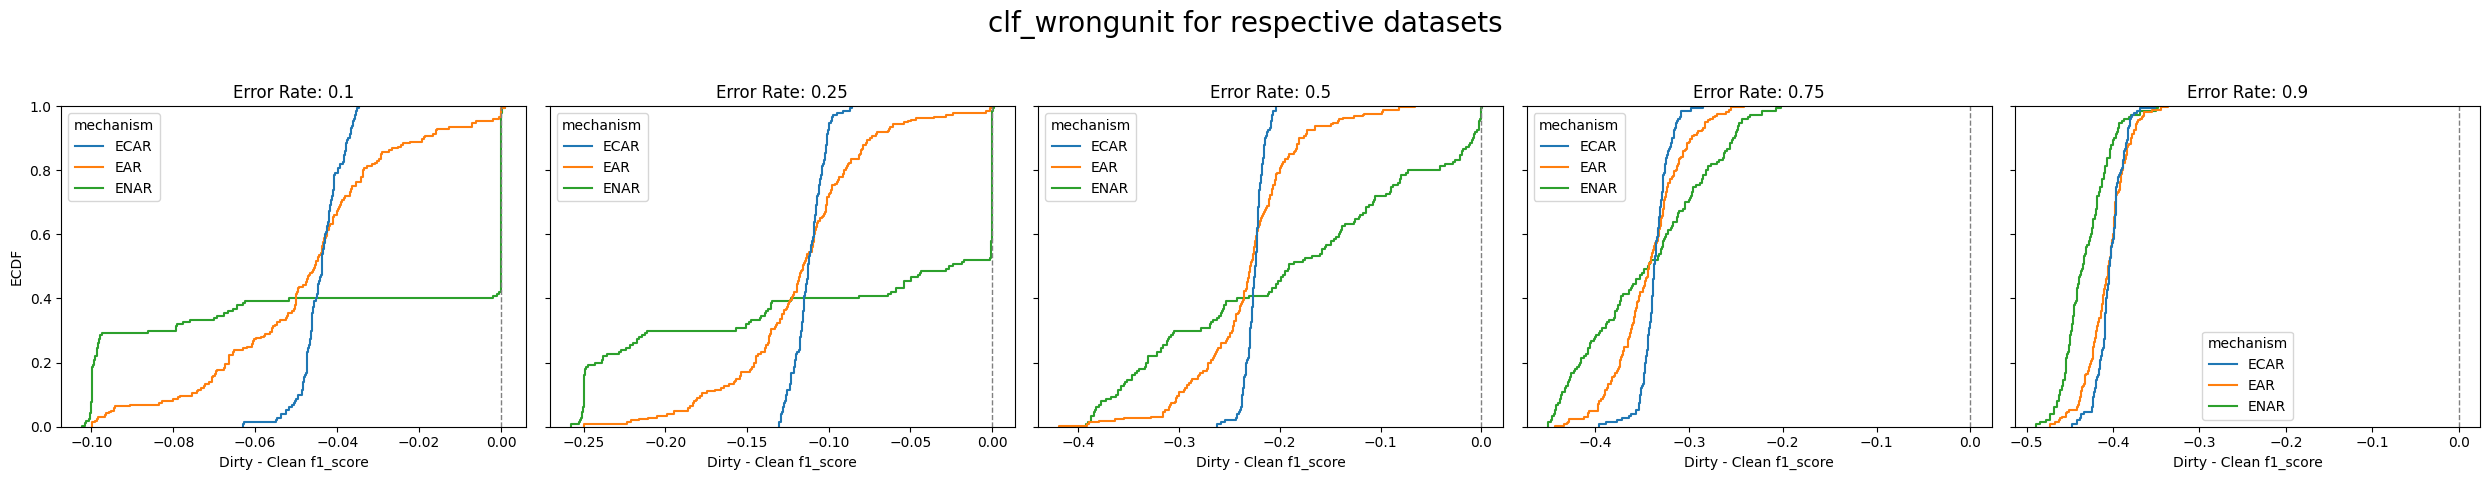

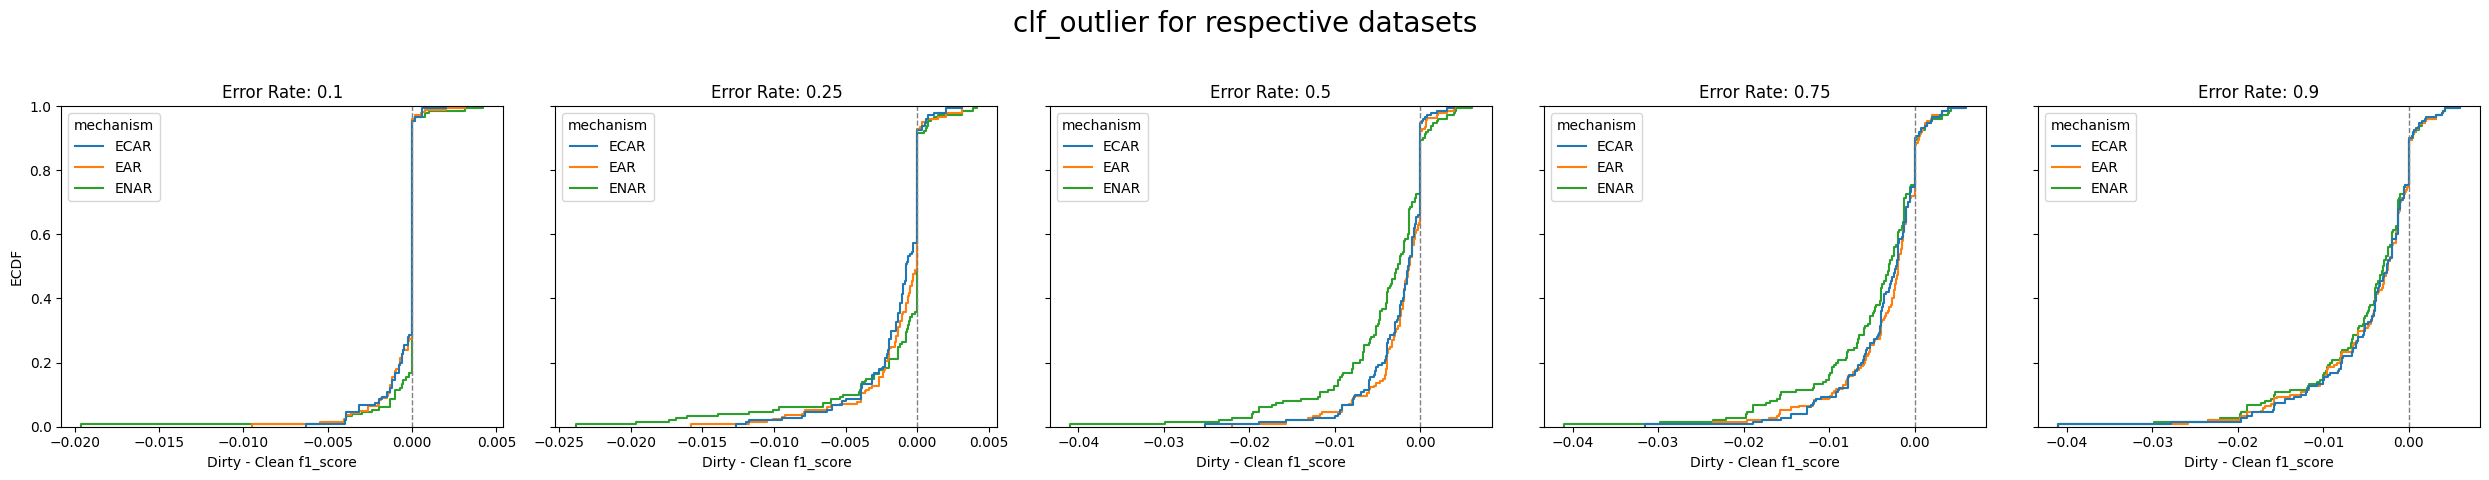

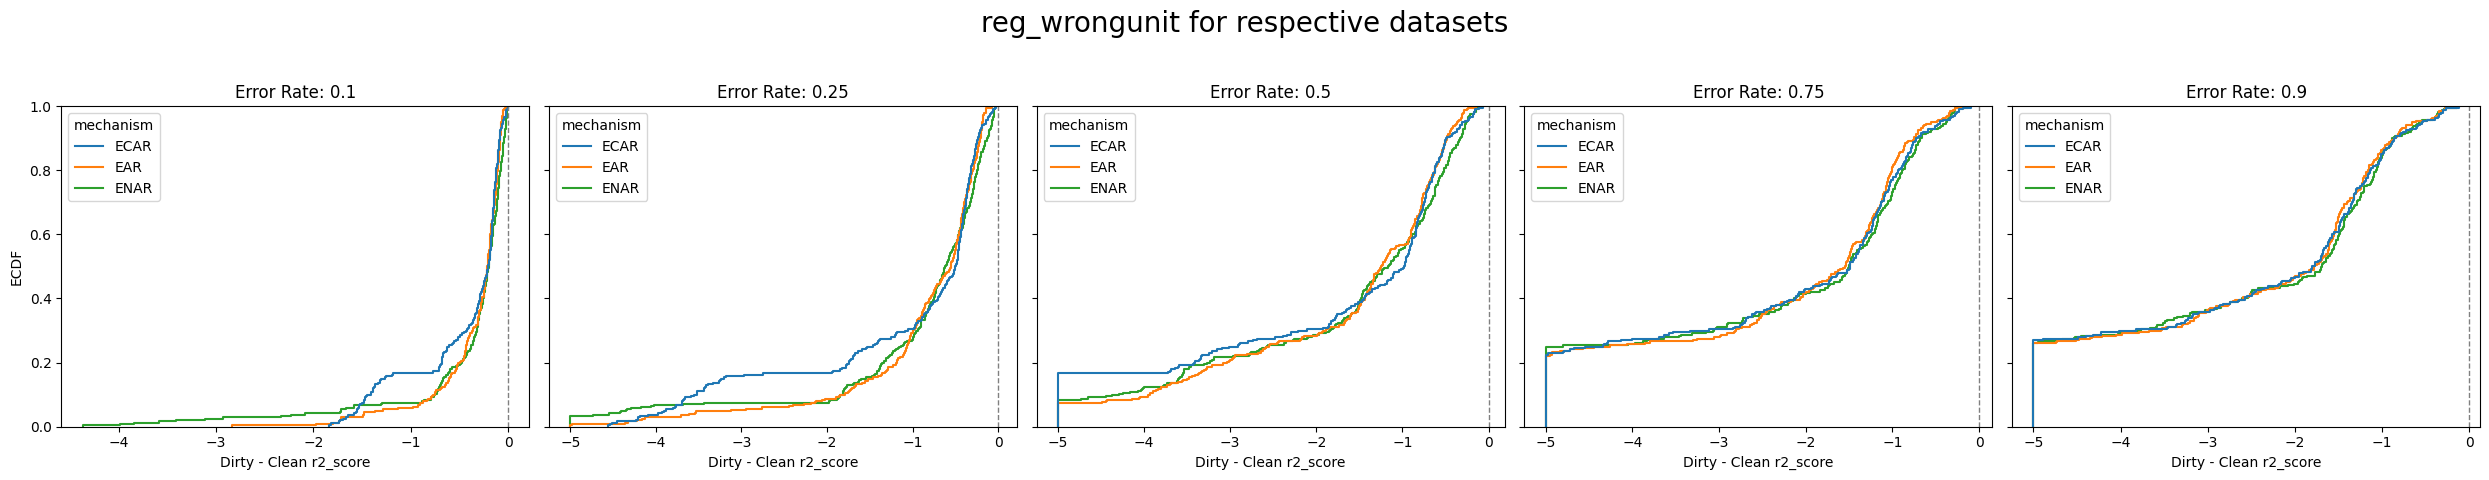

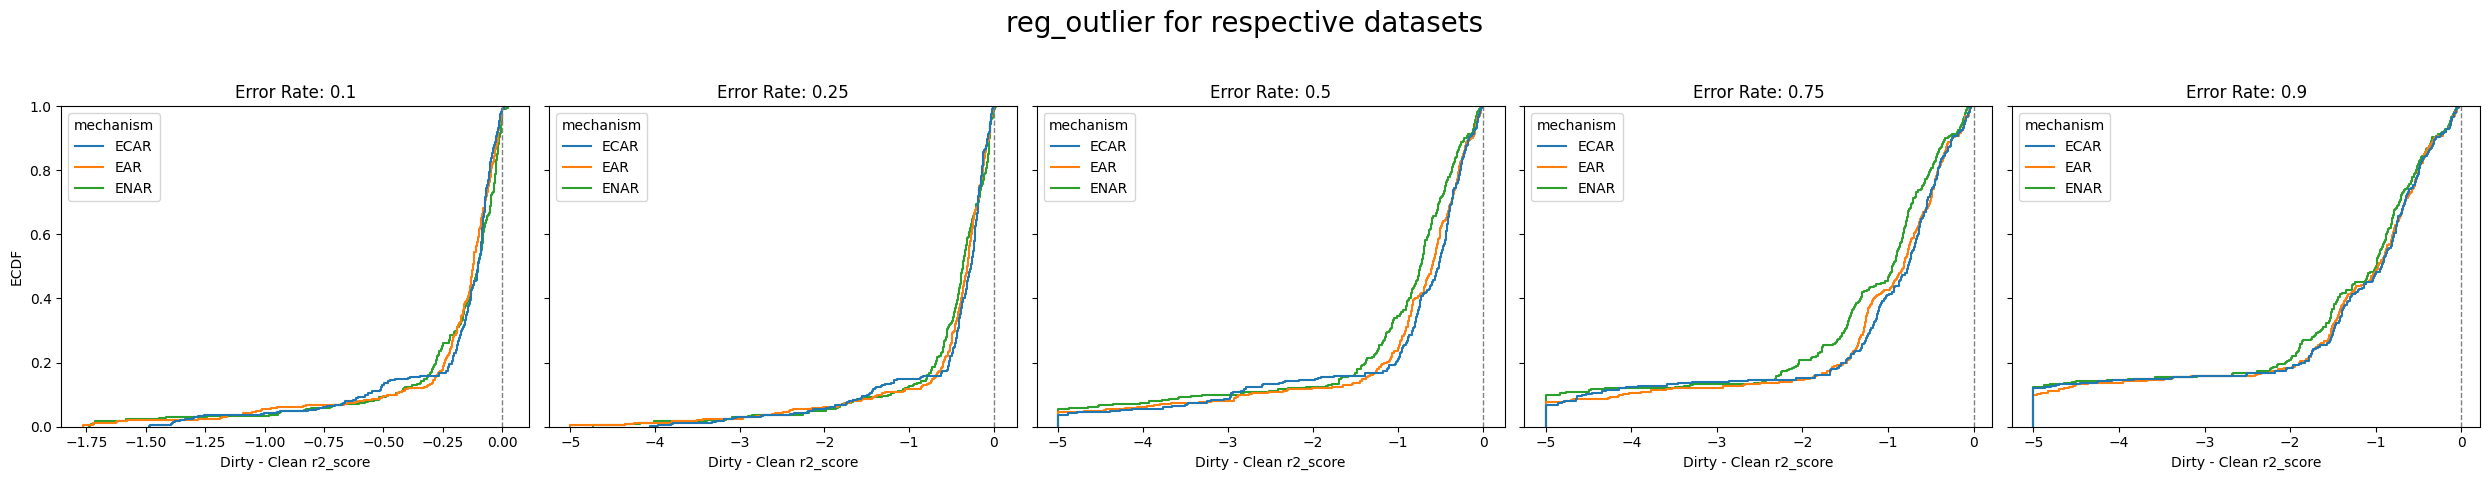

In [10]:
plot_boxplots_by_error_rate(pd.concat([clf_wrongunit_extraneous, clf_wrongunit_typo]), "clf_wrongunit")
plot_boxplots_by_error_rate(pd.concat([clf_outlier_extraneous, clf_outlier_typo]), "clf_outlier")
plot_boxplots_by_error_rate(pd.concat([reg_wrongunit_extraneous, reg_wrongunit_typo]), "reg_wrongunit")
plot_boxplots_by_error_rate(pd.concat([reg_outlier_extraneous, reg_outlier_typo]), "reg_outlier")

plot_ecdfs_by_error_rate(pd.concat([clf_wrongunit_extraneous, clf_wrongunit_typo]), "clf_wrongunit")
plot_ecdfs_by_error_rate(pd.concat([clf_outlier_extraneous, clf_outlier_typo]), "clf_outlier")
plot_ecdfs_by_error_rate(pd.concat([reg_wrongunit_extraneous, reg_wrongunit_typo]), "reg_wrongunit")
plot_ecdfs_by_error_rate(pd.concat([reg_outlier_extraneous, reg_outlier_typo]), "reg_outlier")

Grouped by string error type

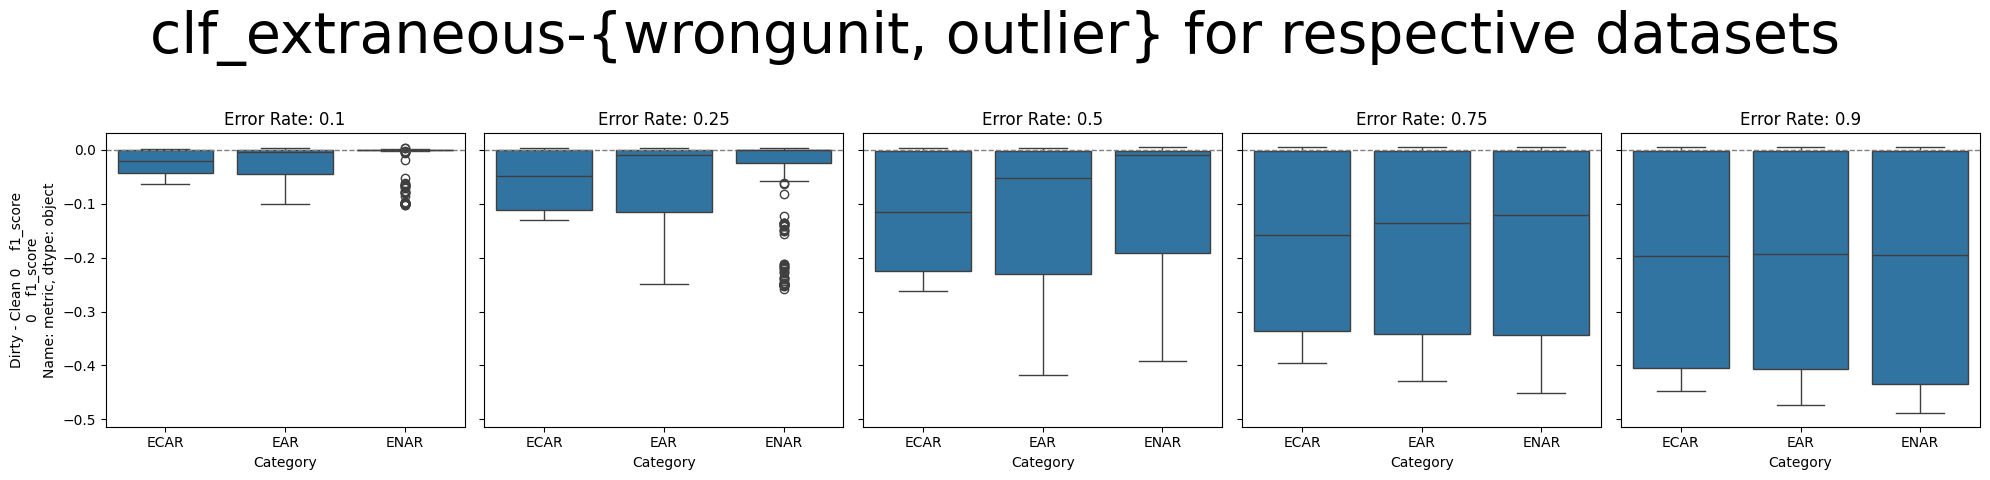

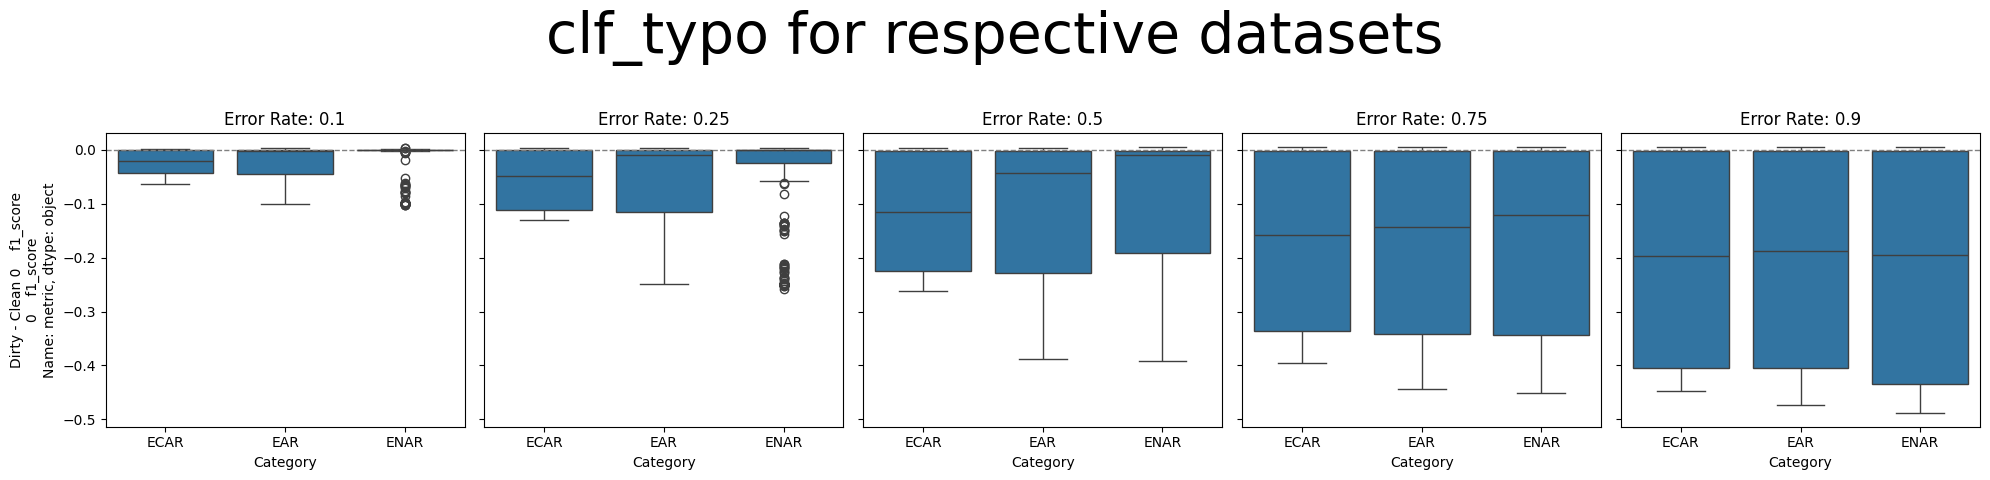

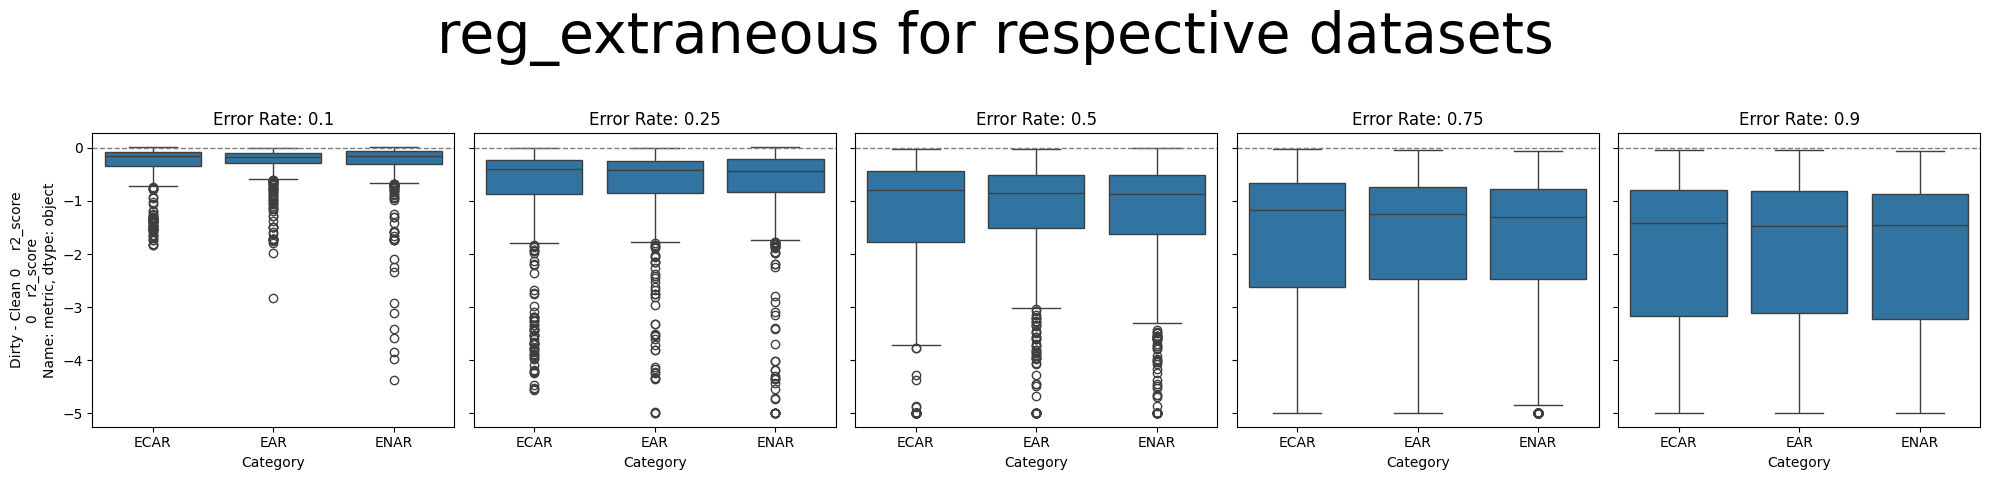

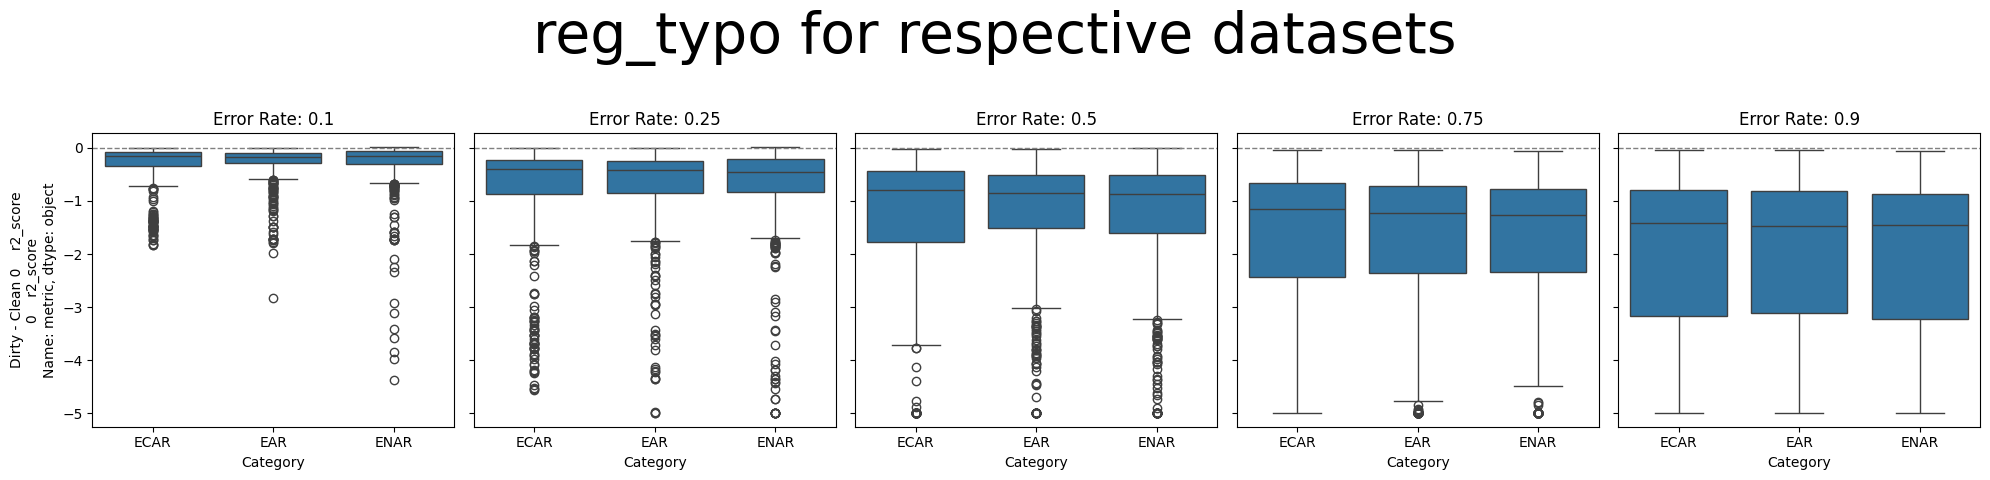

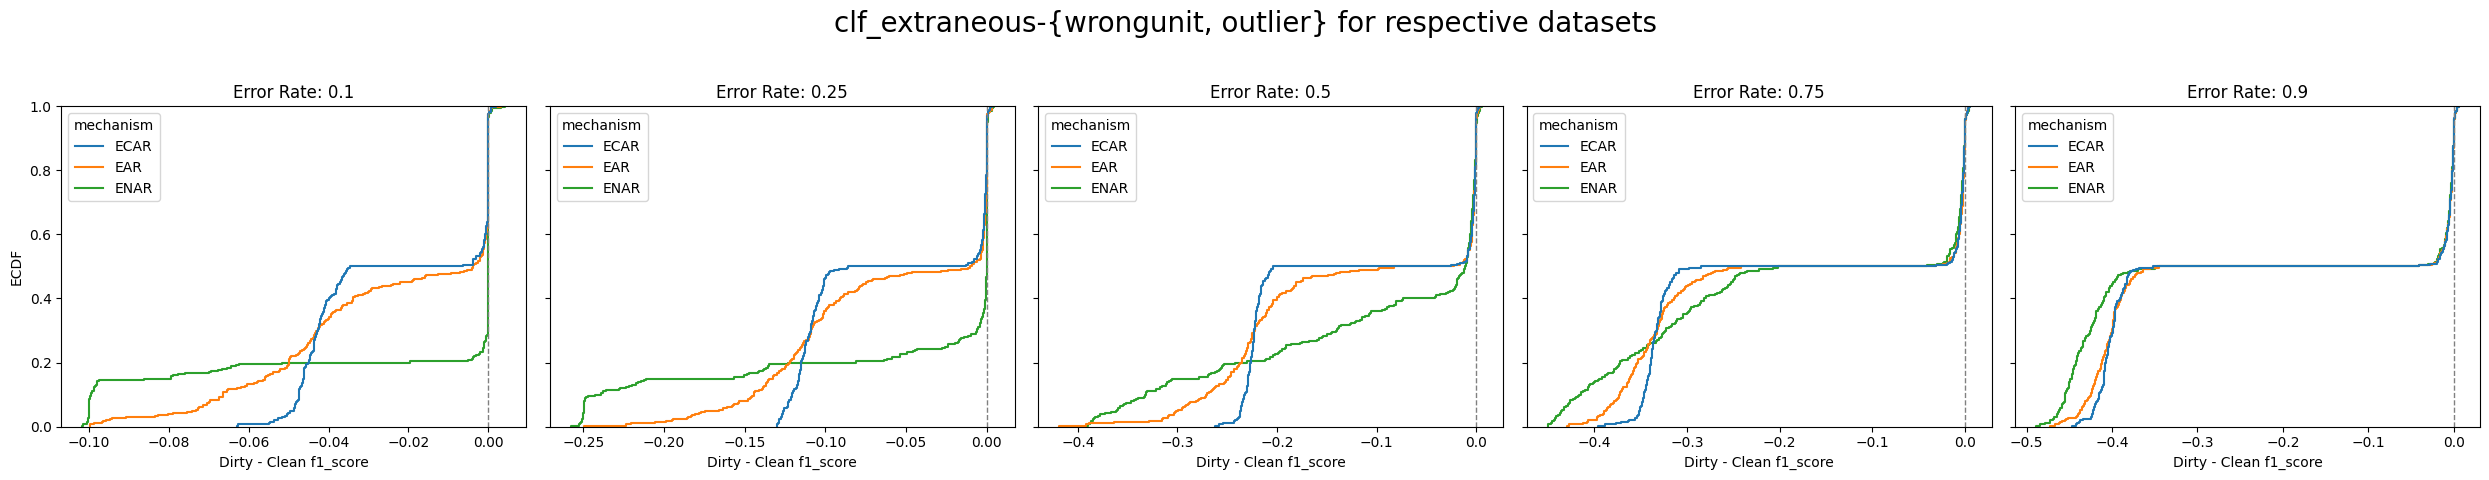

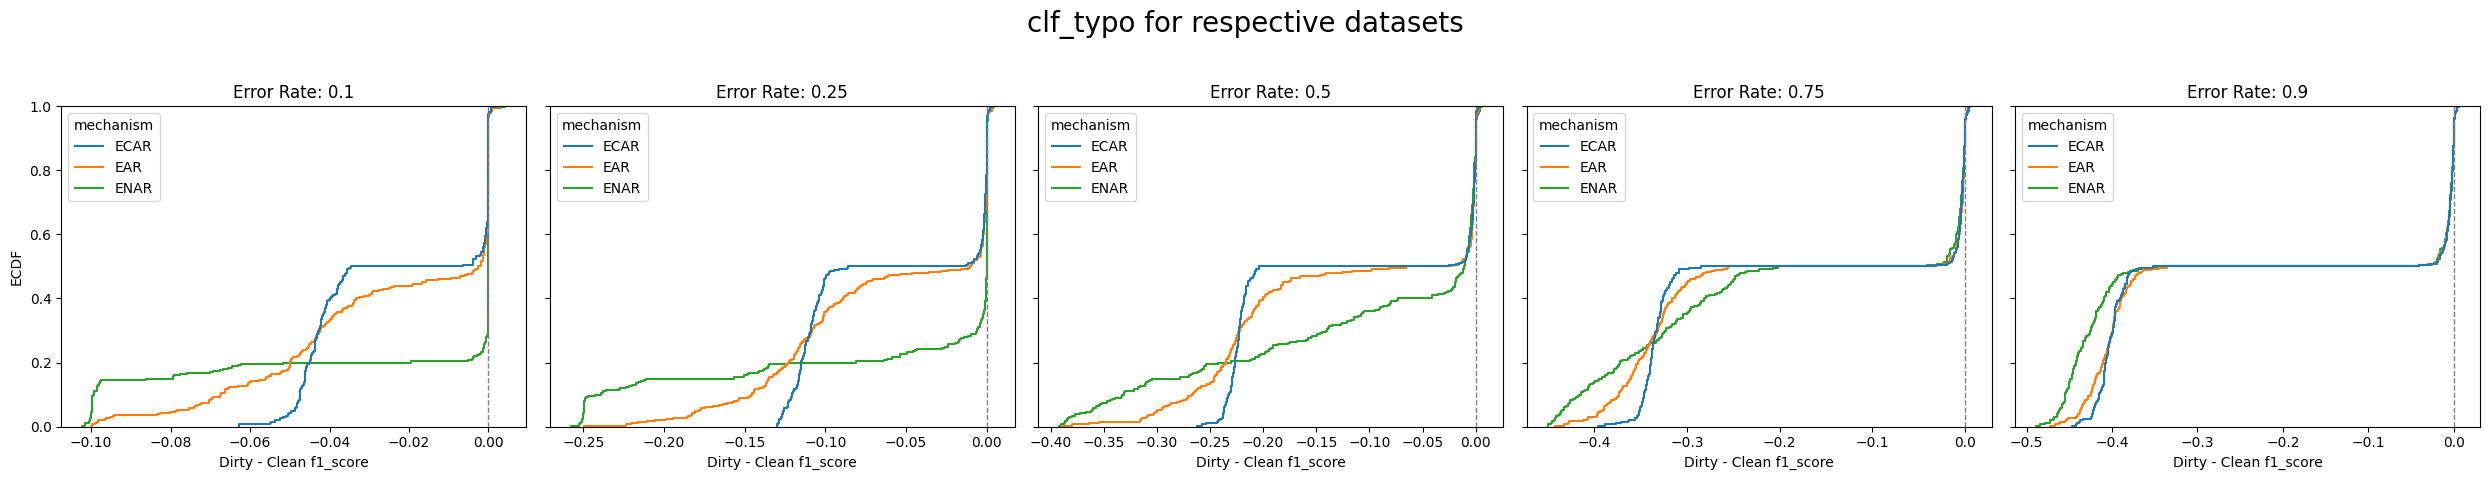

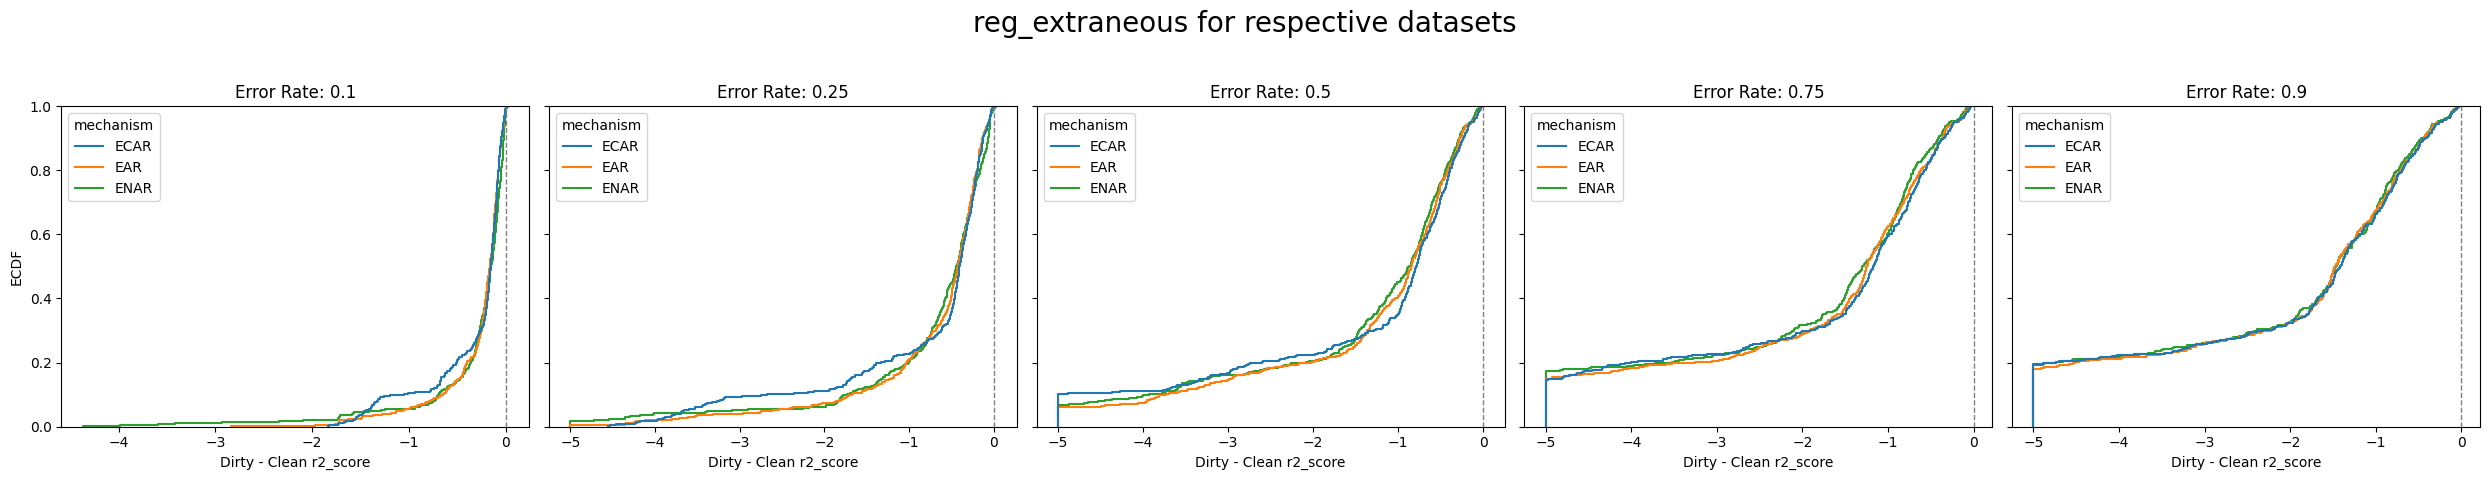

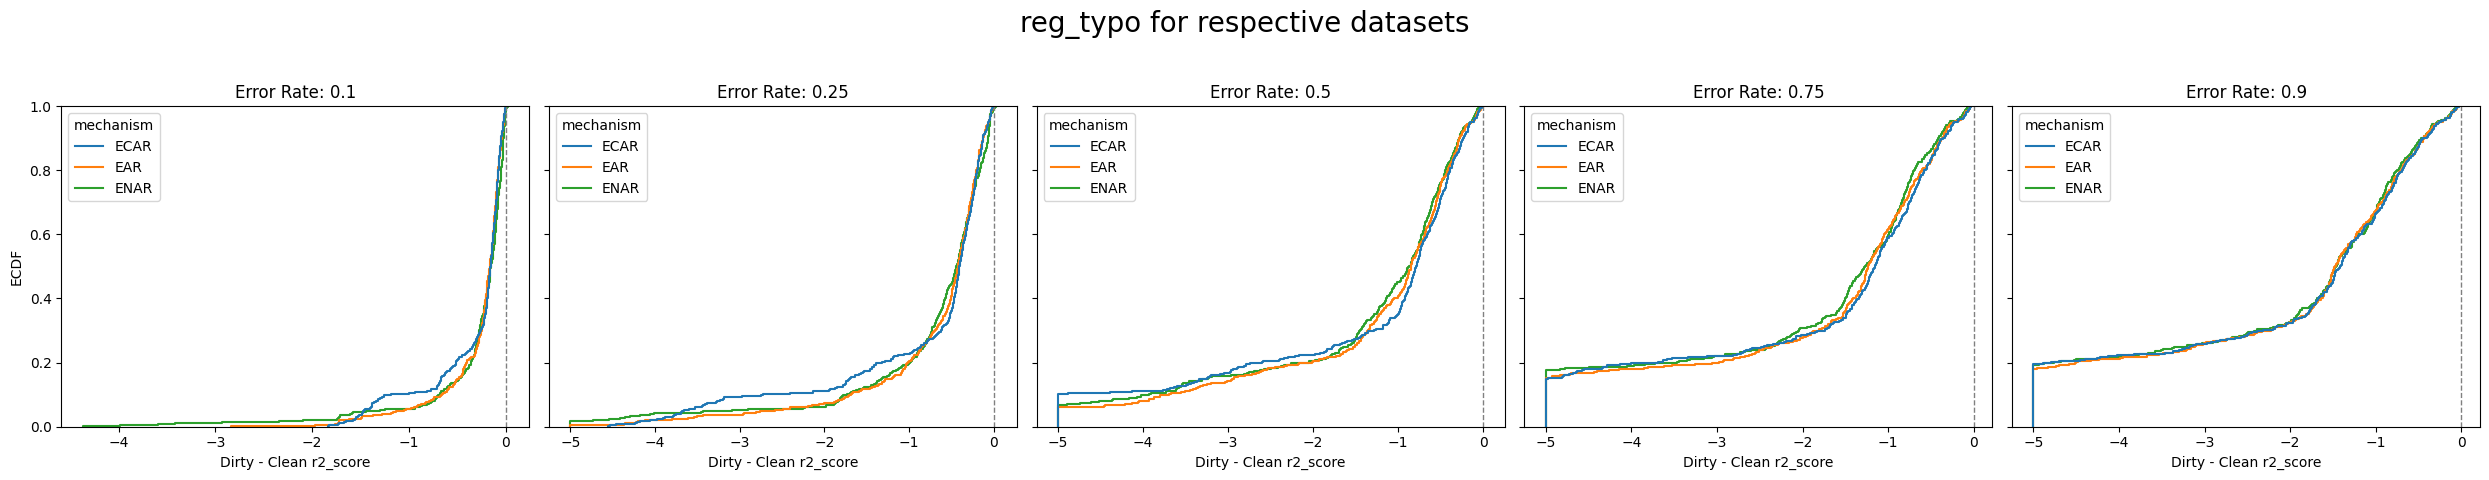

In [9]:
plot_boxplots_by_error_rate(pd.concat([clf_wrongunit_extraneous, clf_outlier_extraneous]), "clf_extraneous-{wrongunit, outlier}")
plot_boxplots_by_error_rate(pd.concat([clf_wrongunit_typo, clf_outlier_typo]), "clf_typo")
plot_boxplots_by_error_rate(pd.concat([reg_wrongunit_extraneous, reg_outlier_extraneous]), "reg_extraneous")
plot_boxplots_by_error_rate(pd.concat([reg_wrongunit_typo, reg_outlier_typo]), "reg_typo")

plot_ecdfs_by_error_rate(pd.concat([clf_wrongunit_extraneous, clf_outlier_extraneous]), "clf_extraneous-{wrongunit, outlier}")
plot_ecdfs_by_error_rate(pd.concat([clf_wrongunit_typo, clf_outlier_typo]), "clf_typo")
plot_ecdfs_by_error_rate(pd.concat([reg_wrongunit_extraneous, reg_outlier_extraneous]), "reg_extraneous")
plot_ecdfs_by_error_rate(pd.concat([reg_wrongunit_typo, reg_outlier_typo]), "reg_typo")

ECDFs

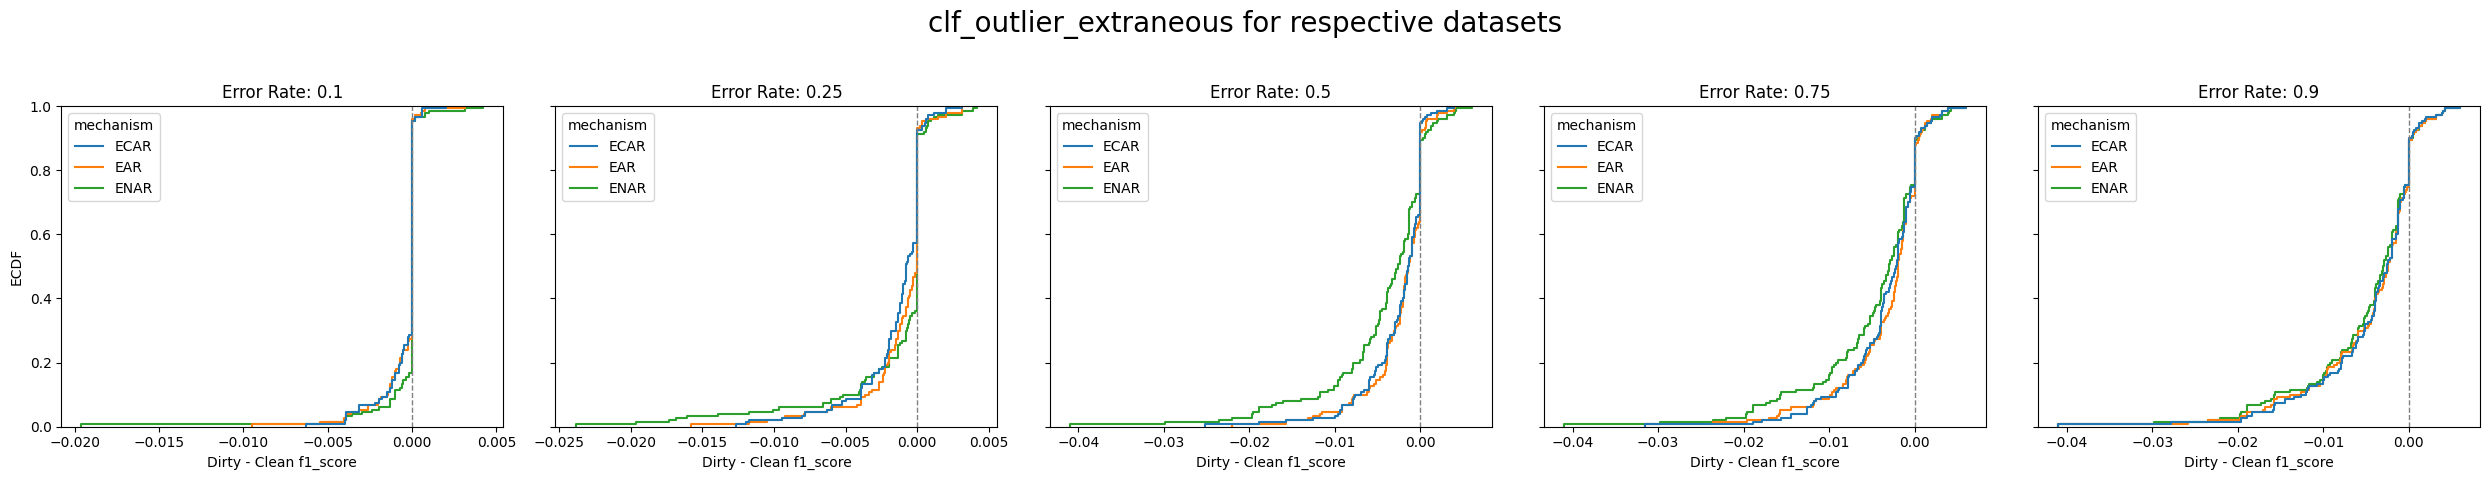

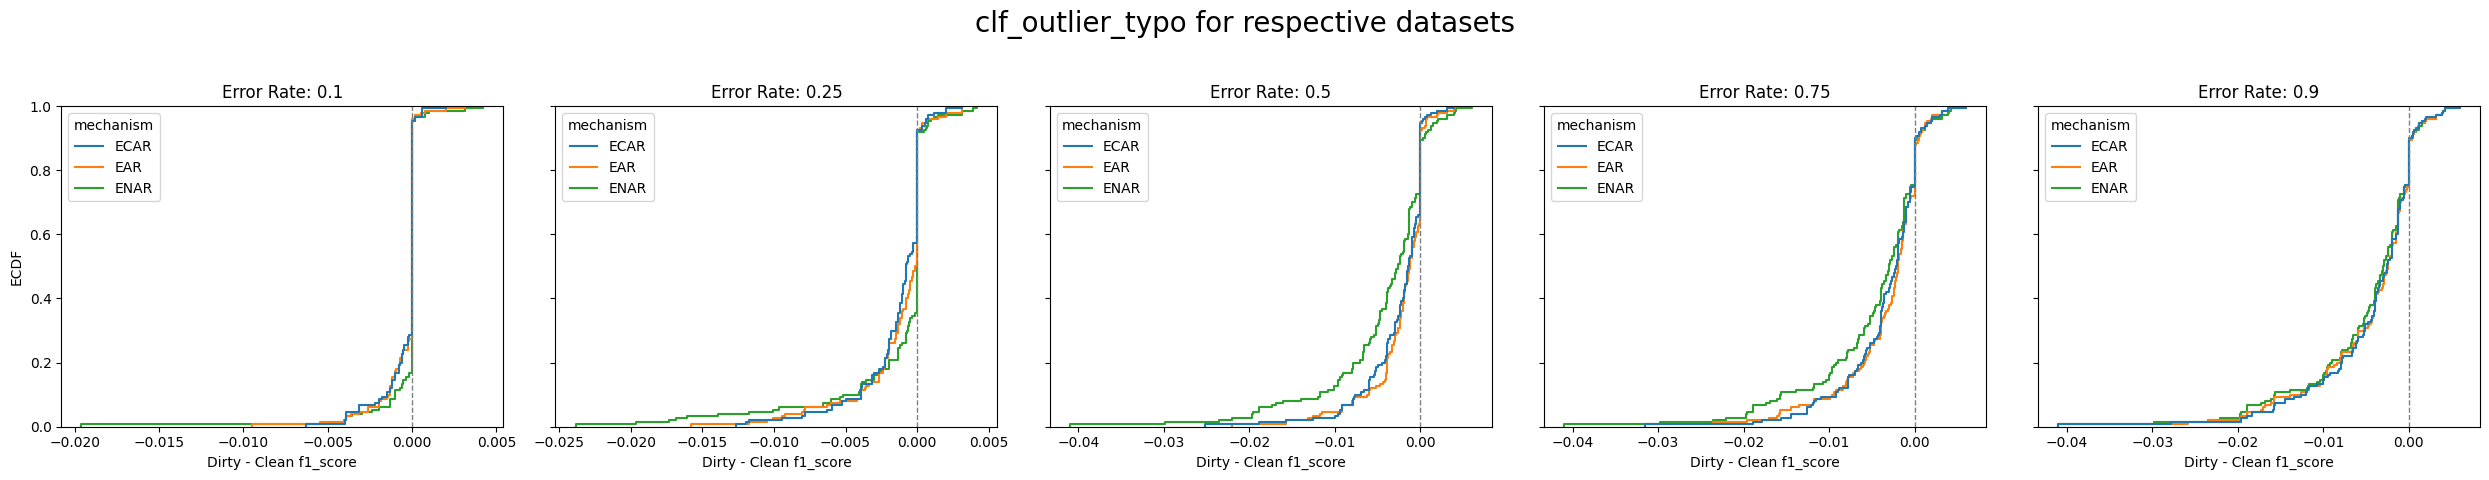

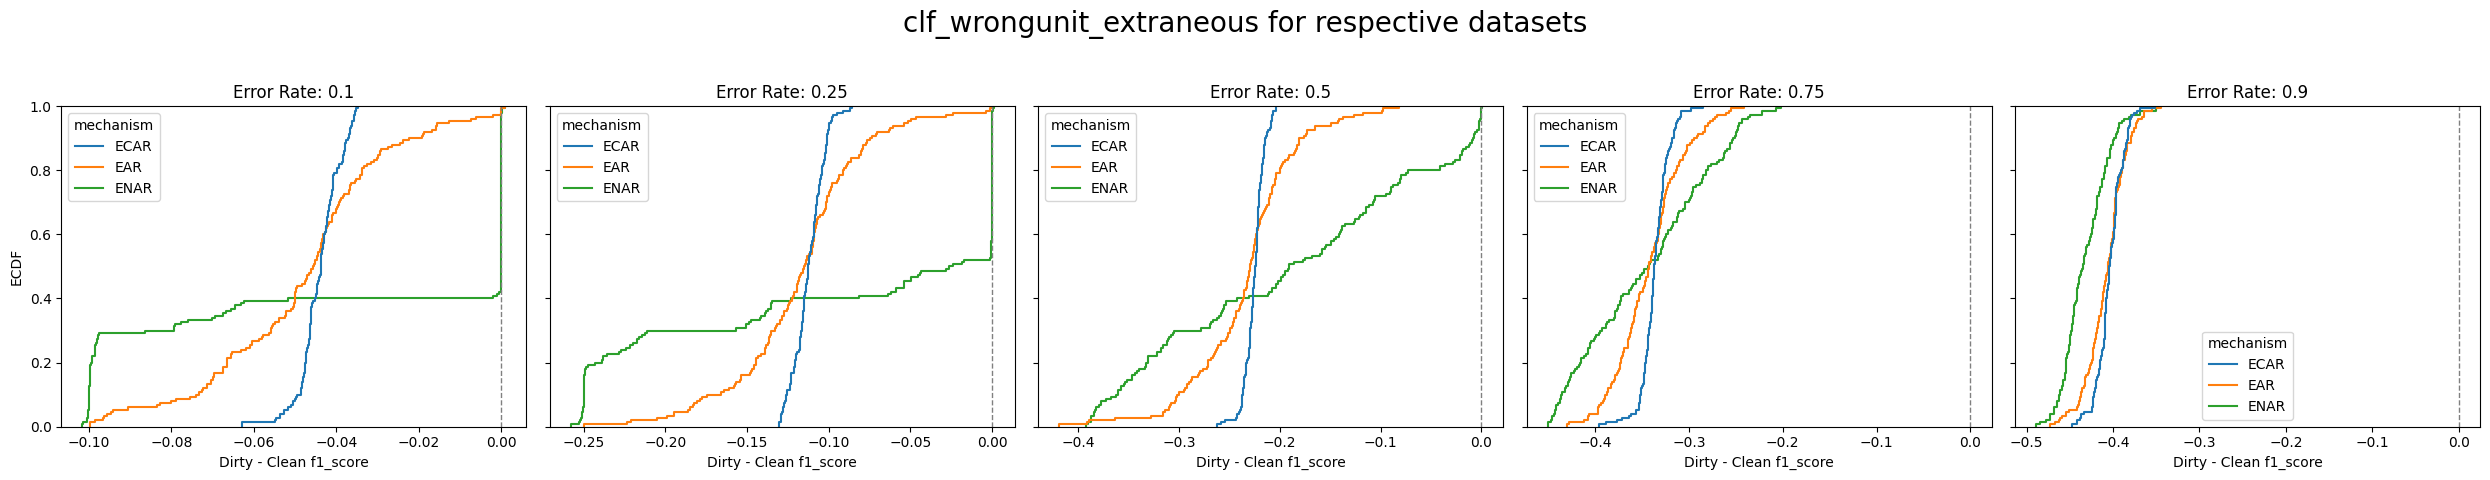

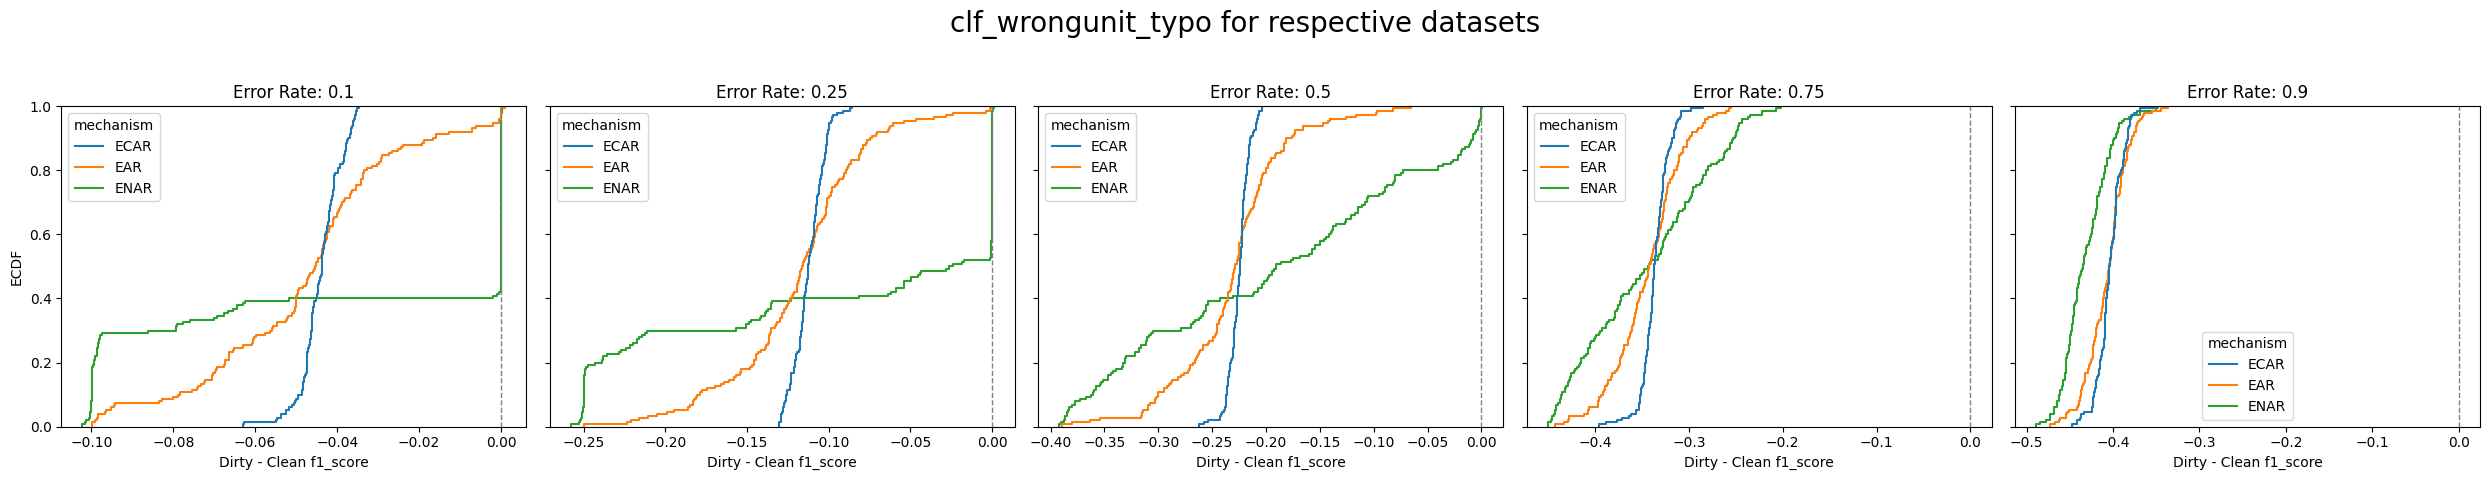

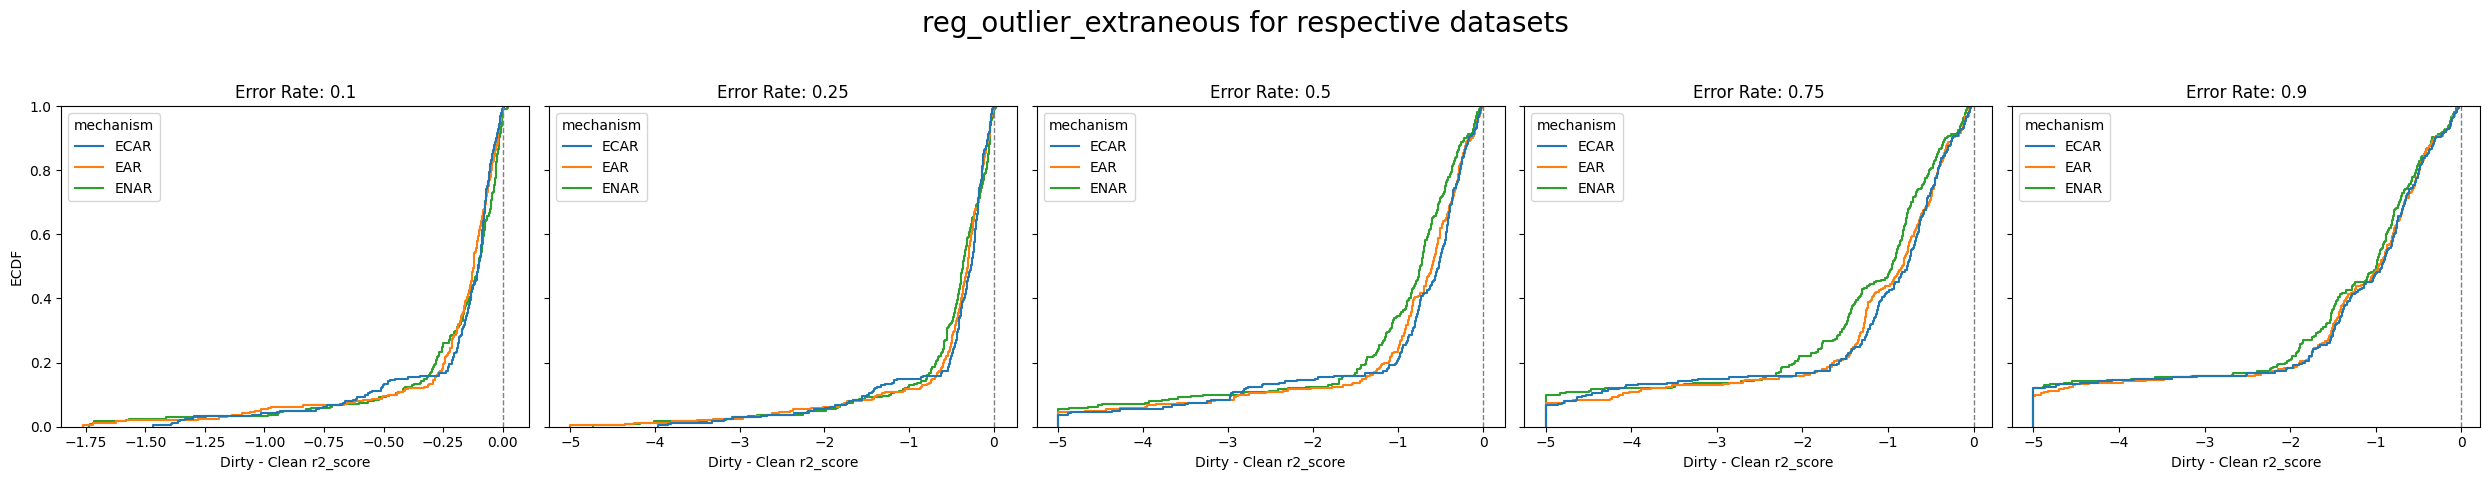

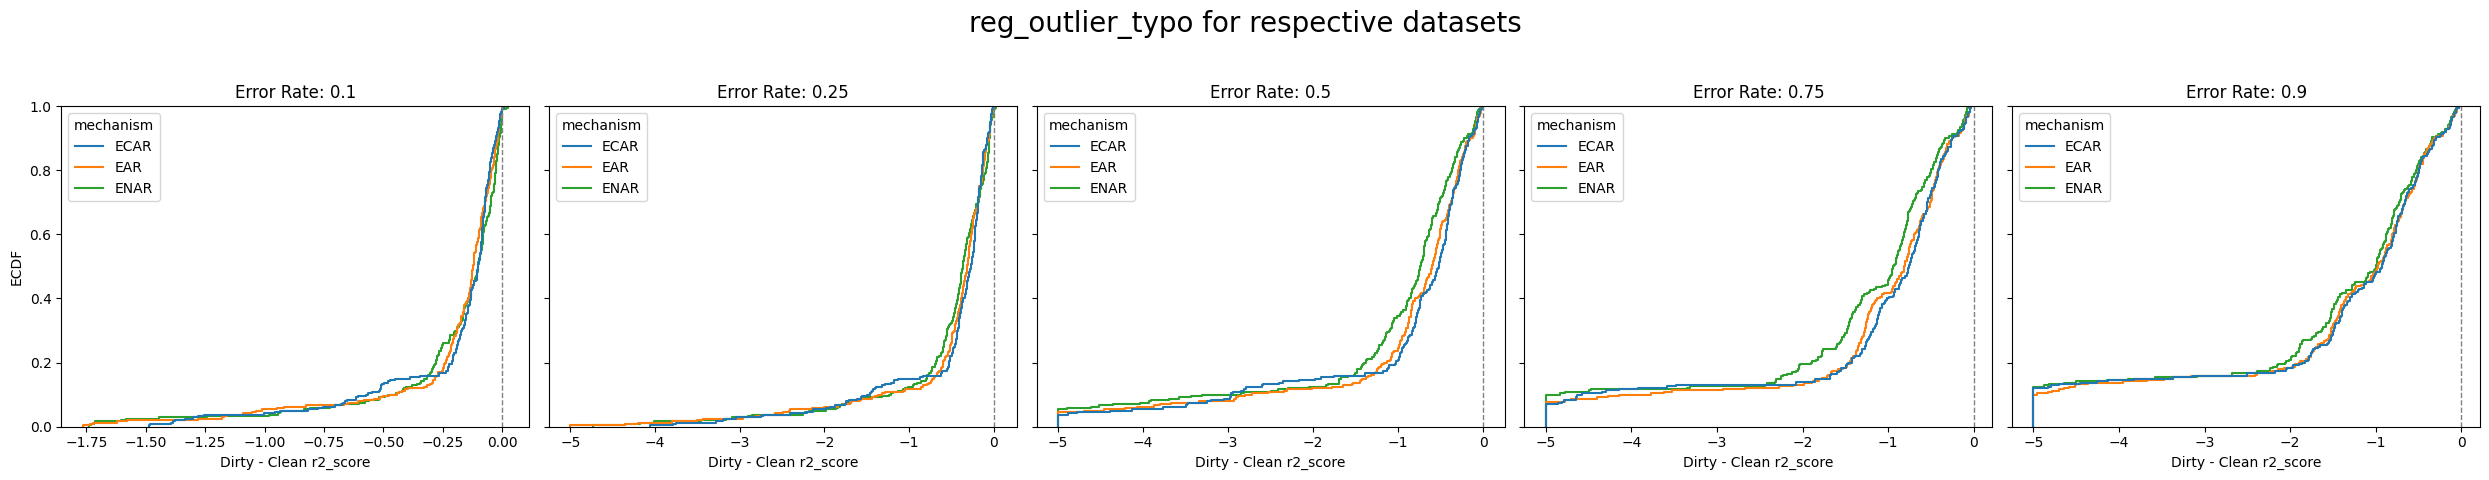

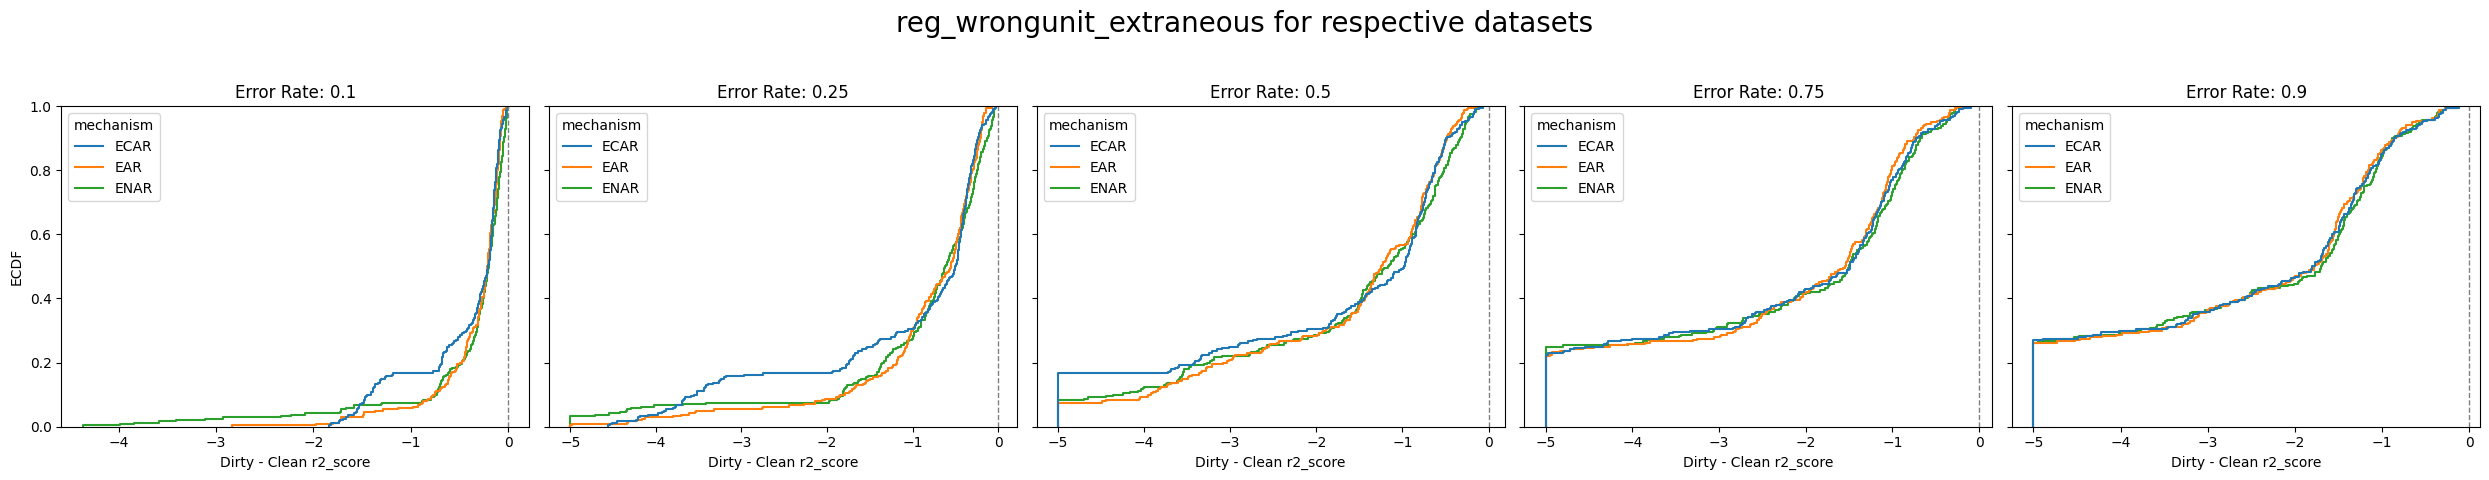

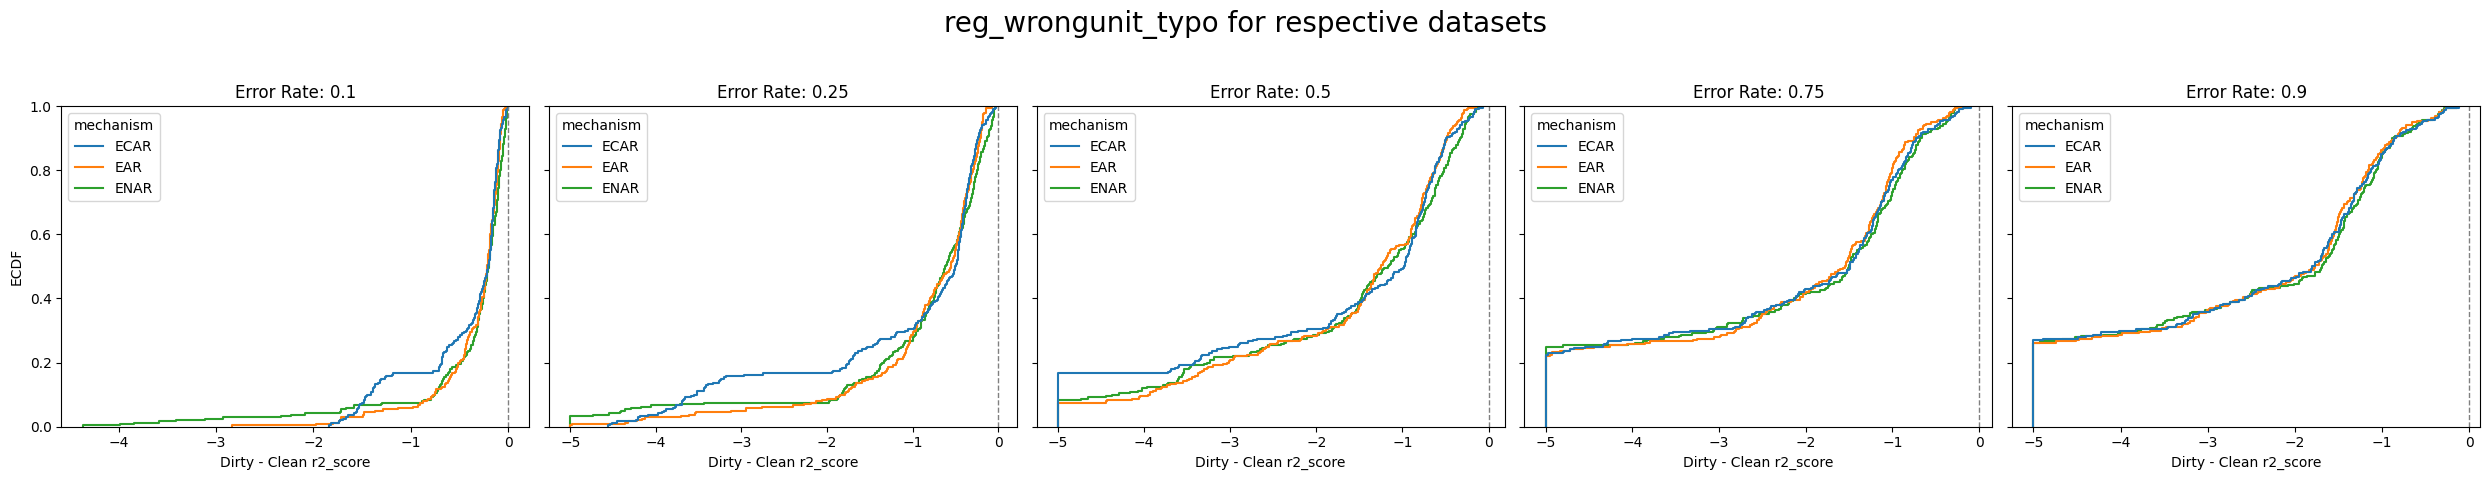

In [71]:
plot_ecdfs_by_error_rate(clf_outlier_extraneous, "clf_outlier_extraneous")
plot_ecdfs_by_error_rate(clf_outlier_typo, "clf_outlier_typo")
plot_ecdfs_by_error_rate(clf_wrongunit_extraneous, "clf_wrongunit_extraneous")
plot_ecdfs_by_error_rate(clf_wrongunit_typo, "clf_wrongunit_typo")


plot_ecdfs_by_error_rate(reg_outlier_extraneous, "reg_outlier_extraneous")
plot_ecdfs_by_error_rate(reg_outlier_typo, "reg_outlier_typo")
plot_ecdfs_by_error_rate(reg_wrongunit_extraneous, "reg_wrongunit_extraneous")
plot_ecdfs_by_error_rate(reg_wrongunit_typo, "reg_wrongunit_typo")